In [166]:
import numpy as np
import pandas as pd
import glob

#preprocessing data tools
from sklearn.preprocessing import MinMaxScaler
from numpy.fft import fft, fftfreq
from scipy import signal
from scipy.io import wavfile

#KNN
from sklearn import neighbors, datasets
from sklearn import metrics

#neural network tools/
#camadas possíveis
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv1D,MaxPooling1D,UpSampling1D, LSTM, RNN
from keras.layers.normalization import BatchNormalization

#leakyrelu permite um gradiente pequeno quando o neurônio não está ativo.
#ela tem uma pequena parte quando potencial de ação é negativo
from keras.layers.advanced_activations import LeakyReLU   
from keras.models import Model,Sequential
from keras.optimizers import Adadelta, RMSprop,SGD,Adam, Nadam
from keras import regularizers
#é sempre bom utilizar callbacks para evitar problemas durante a convergência do algoritmo
from keras import callbacks
#save a model
from keras.models import load_model



#kfold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#ferramentas gráficas
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import chart_studio
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Importando os Dados

In [329]:
path = "/home/gabriel/Downloads/freq/*.wav"
ys = []
fnames = []
y = []
cont = 0
resh = True #habilita ou desabilita divisão dos dados em dados menores.
for fname in sorted(glob.glob(path)): #utiliza a biblioteca glob para varrer a pasta na qual os arquivos (loop)
    
    waveF = []
    fnames.append(fname) 
    print(fname)
    #lê p .wav
    fs, data = wavfile.read(fname)
    #limitando o tamanho das amostras, porque devido ao fato do sensor variar o tamanho da amostra pelo clique do
    #operador, é necessário normalizar
    data = np.array(data[0:150000])
    #dividindo em 10 partes de 15000 amostras, que dá quase um segundo.
    if(resh == True):
        data = np.reshape(data,(10,15000))
        for d in data:
            y.append(d) #adiciona ao vetor de dadas linha a linha os dados
    else:        
        y.append(data)
    if(cont == 13):
        break
    cont += 1

#pega o nome dos arquivos, remove o path deles por espaço.
fnames = [f.replace('C:\\Users\\gabriel.gomes\\Google Drive\\Radice - Pós-Graduação\Disciplinas\Trabalho Final - \
SEL5712 e SEL5742\\Arquivos de Dados\Amostras Aleatórias\\', '') for f in fnames]

#converte y para dataframe
df = pd.DataFrame(np.array(y))

#criando o nome das colunas para o dataframe

#20 = 10 de um lado, 10 do outro
n_samples = 14
index = []
j = 0

if(resh == True):
    for i in range(n_samples*10):
        if(i%n_samples == 0 and i > 0):
            j += 1 
        #da o nome de Amostra (Am) x, parte y (com parte variando de 1 
        #até o número de partes no qual os dados foram divididos)
        index.append("Am." + str(int(i/n_samples)+1) + "p." + str(i-j*n_samples))
else:
    for i in range(n_samples):
        index.append("Am." + str(i))
        
df.index = index
#definindo os labels das amostras: 0 -> sem defeito; 1 -> com defeito
#Assim como cortou as amostras, tem que cortar os labels
n_def = 4;
n_ok = 3;
labels = []
labels[0:int(10*(n_def/(n_ok+n_def))*n_samples+1)] = [1 for i in range(int(10*(n_def/(n_ok+n_def))*n_samples+1))]
labels[int(10*(n_def/(n_ok+n_def))*n_samples+1):] = [0 for i in range(int(10*(n_def/(n_ok+n_def))*n_samples+1),10*n_samples)]
labels = pd.DataFrame(labels)
labels.index = index
#confere se os labels estão ok.
labels.head()

labels_orig = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

/home/gabriel/Downloads/freq/T01_W001_254509454251 Medida 1.wav
/home/gabriel/Downloads/freq/T01_W001_254509457843 Medida 2.wav
/home/gabriel/Downloads/freq/T02_W001_254509457836 Medida 1.wav
/home/gabriel/Downloads/freq/T02_W002_254509457930 Medida 2.wav
/home/gabriel/Downloads/freq/T03_W001_254509457847 Medida 1.wav
/home/gabriel/Downloads/freq/T03_W002_254509457930 Medida 2.wav
/home/gabriel/Downloads/freq/T04_W001_254509457847 Medida 1.wav
/home/gabriel/Downloads/freq/T04_W002_254509457950 Medida 2.wav
/home/gabriel/Downloads/freq/T05_W001_254509457819 Medida 1.wav
/home/gabriel/Downloads/freq/T05_W001_254509457819 Medida 2.wav
/home/gabriel/Downloads/freq/T06_W001_254509457815 Medida 1.wav
/home/gabriel/Downloads/freq/T06_W002_254509457853 Medida 2.wav
/home/gabriel/Downloads/freq/T07_W001_254509457835 Medida 1.wav
/home/gabriel/Downloads/freq/T07_W002_254509457925 Medida 2.wav


# Análise do espectro de frequência dos sinais e classificação por espectro de frequência
Análise da resposta em frequência dos sinais sem defeito e dos sinais com defeito. Foi utilizada a FFT média para analisar a semelhança ou diferença entre os espectros médios.

In [331]:
#faz a fft de uma linha só para não ter que ficar fazendo toda hora
#uma análise diferente do tamanho do vetor

#janela de alisamento aplicada na transformada de fourier para alisar o espectro
window = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f, Pxx_den = signal.periodogram(df.iloc[0][:], fs)
Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
meanf_ok = Pxx_den - Pxx_den #cria vetor de nulos
meanf_nok = Pxx_den - Pxx_den #cria vetor de nulos
count_ok = 0
count_nok = 0
fourier = []
#faz a média dos espectros de frequência com defeito e sem defeito
for i in range(len(df)):
    f, Pxx_den = signal.periodogram(df.iloc[i][:], fs)
    Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
    if(labels.iloc[i][0] == 0):
        #meanf_ok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den)) #normalizando os coeficientes.
        meanf_ok += Pxx_den/max(Pxx_den)
        fourier.append((Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))) #resultado da transformada de Fourier
        count_ok += 1
    else:
        fourier.append((Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))) #resultado da transformada de Fourier
        meanf_nok += Pxx_den/max(Pxx_den)
        #?meanf_nok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))
        count_nok += 1


### Transformada de Fourier Janelada de um sinal com defeito e um sem

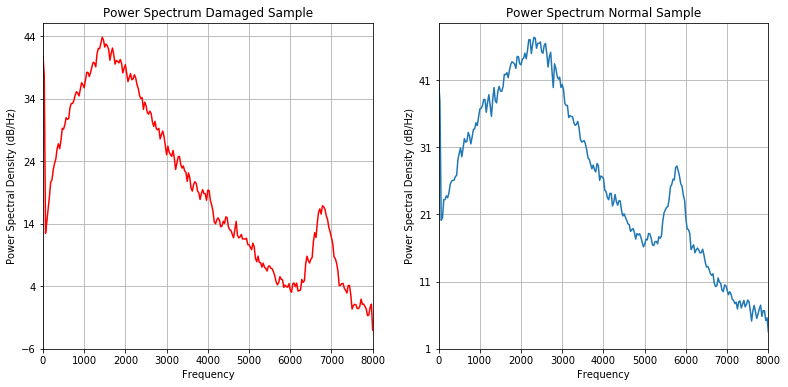

In [332]:
#amostras individuais
plt.figure(figsize=(13, 6))
plt.subplot(1,2,1)
plt.psd(df.iloc[0][:],512,fs, c = 'r')
plt.title("Power Spectrum Damaged Sample")
plt.xlim([0, 8000])
plt.subplot(1,2,2)
plt.psd(df.iloc[13][:],512,fs)
plt.title("Power Spectrum Normal Sample")
plt.xlim([0, 8000])
plt.show()

### Expectro médio de Fourier

In [334]:
        
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)


#cria um dataframe dos isoladores com defeito e sem defeito
# fourier_df = pd.DataFrame(np.array([f, meanf_nok, meanf_ok]).T)
# fourier_df.columns = ["Frequency [Hz]", "Broken", "Normal"]
# fourier_df.head()
f_df = pd.DataFrame(f.T)
f_df.columns = ["Frequency"]
meanf_nok_df = pd.DataFrame(meanf_nok.T)
meanf_nok_df.columns = ["Broken Insulator"]
meanf_ok_df = pd.DataFrame(meanf_ok.T)
meanf_ok_df.columns = ["Normal Insulator"]
# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))

#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_nok_df['Broken Insulator'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_ok_df['Normal Insulator'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_nok_df['Broken Insulator'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_ok_df['Normal Insulator'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Frequency [Hz]',
                   yaxis_title='Modulus')

fig.show()

## Cortando o espectro

O espectro será cortado acima de 500 Hz e abaixo de 3000 Hz. Isso porque eles são iguais nessas regiões.

In [335]:
#Cortando na região de interesse

fu_cutted = []
f_cut_sup = 3000
f_cut_inf = 500
l_inf = int(f_cut_inf*len(f_df)/8000)
l_sup = int(f_cut_sup*len(f_df)/8000)
for fou in np.array(fourier):
    fu_cutted.append(fou[l_inf:l_sup])
meanf_ok = fu_cutted[0] - fu_cutted[0] #cria vetor de nulos
meanf_nok = fu_cutted[0]- fu_cutted[0] #cria vetor de nulos

    
    
for i in range(len(fu_cutted)):
    if(labels.iloc[i][0] == 0):
        #meanf_ok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den)) #normalizando os coeficientes.
        meanf_ok += fu_cutted[i]/max(fu_cutted[i])
        count_ok += 1
    else:
        meanf_nok += fu_cutted[i]/max(fu_cutted[i])
        #?meanf_nok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))
        count_nok += 1

In [337]:

#cortando o espectro de frequência
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)



f_df = pd.DataFrame(f[l_inf:])
f_df.columns = ["Frequency"]
meanf_nok_df = pd.DataFrame(meanf_nok.T)
meanf_nok_df.columns = ["Broken Insulator"]
meanf_ok_df = pd.DataFrame(meanf_ok.T)
meanf_ok_df.columns = ["Normal Insulator"]

# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))


#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_nok_df['Broken Insulator'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_ok_df['Normal Insulator'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_nok_df['Broken Insulator'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_ok_df['Normal Insulator'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Frequency [Hz]',
                   yaxis_title='Modulus')

fig.show()

Como é possível ver, existe uma diferença média no espectro entre 1000 e 2000 Hz. Portanto, os espectros médios da janela são diferentes! Logo, podemos utilizar a transformada de Fourier Janelada para fazer a análise.

Como a transformada de Fourier possui muitas amostras, no caso, 2344, devemos fazer uma reamostragem para tornar isso compatível com a rede. Iremos fazer isso utilizando uma subamostragem por Fourier (vulgo método de compactação de MP3)! Essa subamostragem por Fourier se comporta como uma compactação. 

In [339]:
# nas redes neurais.
data = signal.resample(fu_cutted,30,axis = 1) #subamostrando segundo as colunas.

# comparar o signal reconstruído com o subamostrado
fourier_recomp = signal.resample(data,len(fu_cutted[0]), axis = 1)

In [340]:
#Coeficiente de correlação foi para 0.71 porem, o importante é saber se o espectro médio atinda tem diferença!
corr = []
for i in range(140):
    corr.append(np.corrcoef(fourier_recomp[i], fu_cutted[i]))

print("Valor Mínimo: ", np.min(corr))
print("Valor Máximo: ", np.max(corr))
    

Valor Mínimo:  0.9967202287006263
Valor Máximo:  1.0


## análise do sinal compactado
Foi analisada a compactação do sinal para ver se ela ainda mantinha a separabilidade entre os espectros médios.

In [341]:
#faz a média dos espectros de frequência com defeito e sem defeito subamostrados
meanf_ok = data[1] - data[1] #cria vetor de nulos
meanf_nok = data[1] - data[1]#cria vetor de nulos
count_ok = 0
count_nok = 0
fourier_norm = [] #fourier normalizado
for i in range(len(labels)):
    if(labels.iloc[i][0] == 0):
        data[i] = (data[i]/max(data[i])) #normaliza o dado pelo máximo
        meanf_ok += data[i]
        count_ok += 1 #contador para verificar se o número de amostras sem defeito está correto
    else:
        data[i] = (data[i]/max(data[i]))
        meanf_nok += data[i]
        count_nok += 1 #contador para verificar se o número de amostras com defeito está correto

In [342]:
        
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)

f = [i for i in range(len(meanf_ok))] #cria o vetor de tempo
#cria um dataframe dos isoladores com defeito e sem defeito
fourier_df = pd.DataFrame(np.array([f, meanf_nok, meanf_ok]).T)
fourier_df.columns = ["Frequency [Hz]", "Broken", "Normal"]
fourier_df.head()

# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))

#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Samples',
                   yaxis_title='Modulus')

fig.show()

Como é possível perceber, a diferença no espectro de frequência foi preservada, logo essa abordagem pode ser utilizada.
Uma outra possibilidade é utilizar um PCA aqui. O problema é que como temos apenas 200 amostras, vai ser difícil preservar a variância porque o máximo de coeficientes possível serão 200, então nem compensa tentar. 


# Rede Neural

In [343]:
#colocando as informações no formato da rede. Tem que expandir uma dimensão
data = np.expand_dims(np.array(data),axis= 2) 

In [182]:
# # #callbacks
#hackeando os critérios de earlystop da biblioteca.
#colocando para parar quando atinge a métrica desejada
class EarlyStoppingByLossVal(callbacks.Callback):
     def __init__(self, monitor='custom', value=0.95, verbose=0):
         super(callbacks.Callback, self).__init__()
         self.monitor = monitor
         self.value = value
         self.verbose = verbose

     def on_epoch_end(self, epoch, logs={}):
         self.monitor = 'val_acc'
         val_ac = logs.get(self.monitor)
         self.monitor = 'acc'
         ac = logs.get(self.monitor)
         if (val_ac or ac)is None:
             warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

         if (val_ac >= self.value) and (ac >= 0.95):
             if self.verbose > 0:
                 print("Epoch %05d: early stopping THR" % epoch)
             self.model.stop_training = True

callbacks = [
    EarlyStoppingByLossVal(monitor='custom', value=0.89, verbose=1),
]

Usando k-fold cross validation

In [260]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)

In [261]:
treinamento = []
teste = []
for train,test in kfold.split(data,labels):
    treinamento.append(train)
    teste.append(test)


In [262]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Modelo 1 -> MLP tradicional

In [357]:
convolutional_NN = Sequential()
convolutional_NN.add(Dense(50,activation = 'relu', input_shape=(data.shape[1],1)))
convolutional_NN.add(Dense(40,activation = 'relu'))
convolutional_NN.add(Dense(40,activation = 'relu'))
convolutional_NN.add(Dense(40,activation = 'relu'))
convolutional_NN.add(Dense(30,activation = 'relu'))
convolutional_NN.add(Dense(30,activation = 'relu'))
# convolutional_NN.add(Conv1D(50,kernel_size = 15, activation = 'relu', input_shape=(data.shape[1],1)))
# convolutional_NN.add(Conv1D(40,kernel_size = 10, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(Flatten())
    #camada de saída: MLP com 1 neurônio e função de ativação sigmoid
convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    
    #Compila o modelo. Função de custo: erro médio quadrático. Otimizador: Adam.
convolutional_NN.compile(loss='binary_crossentropy', optimizer = Nadam(),metrics=['accuracy'],  
                             )
    
    # Fit o modelo por 30 épocas e batch_size = 64. Já está validando também
convolutional_NN.fit(data[treinamento[0]], np.array(labels)[treinamento[0]], epochs=1300, callbacks = callbacks,
                     batch_size=140, verbose=1
                         , validation_data=(data[teste[0]], np.array(labels)[teste[0]]))
    # avalia o resultado
scores = convolutional_NN.evaluate(data[teste[0]], np.array(labels)[teste[0]], verbose=0)
print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))


Train on 112 samples, validate on 28 samples
Epoch 1/1300
112/112 [==============================] - 22s 193ms/step - loss: 0.6916 - acc: 0.5714 - val_loss: 0.6899 - val_acc: 0.5714
Epoch 2/1300
112/112 [==============================] - 0s 194us/step - loss: 0.6895 - acc: 0.5714 - val_loss: 0.6876 - val_acc: 0.5714
Epoch 3/1300
112/112 [==============================] - 0s 155us/step - loss: 0.6871 - acc: 0.5714 - val_loss: 0.6852 - val_acc: 0.5714
Epoch 4/1300
112/112 [==============================] - 0s 194us/step - loss: 0.6845 - acc: 0.5714 - val_loss: 0.6830 - val_acc: 0.5714
Epoch 5/1300
112/112 [==============================] - 0s 152us/step - loss: 0.6821 - acc: 0.5714 - val_loss: 0.6816 - val_acc: 0.5714
Epoch 6/1300
112/112 [==============================] - 0s 190us/step - loss: 0.6805 - acc: 0.5714 - val_loss: 0.6809 - val_acc: 0.5714
Epoch 7/1300
112/112 [==============================] - 0s 200us/step - loss: 0.6797 - acc: 0.5714 - val_loss: 0.6800 - val_acc: 0.5714
Ep

Epoch 61/1300
112/112 [==============================] - 0s 257us/step - loss: 0.5063 - acc: 0.7321 - val_loss: 0.5711 - val_acc: 0.7857
Epoch 62/1300
112/112 [==============================] - 0s 271us/step - loss: 0.5037 - acc: 0.7143 - val_loss: 0.5164 - val_acc: 0.7857
Epoch 63/1300
112/112 [==============================] - 0s 260us/step - loss: 0.5056 - acc: 0.7411 - val_loss: 0.5653 - val_acc: 0.7857
Epoch 64/1300
112/112 [==============================] - 0s 242us/step - loss: 0.5004 - acc: 0.7143 - val_loss: 0.5150 - val_acc: 0.7857
Epoch 65/1300
112/112 [==============================] - 0s 184us/step - loss: 0.4999 - acc: 0.7500 - val_loss: 0.5573 - val_acc: 0.7857
Epoch 66/1300
112/112 [==============================] - 0s 209us/step - loss: 0.4950 - acc: 0.7143 - val_loss: 0.5143 - val_acc: 0.7857
Epoch 67/1300
112/112 [==============================] - 0s 214us/step - loss: 0.4939 - acc: 0.7411 - val_loss: 0.5520 - val_acc: 0.7857
Epoch 68/1300
112/112 [==================

Epoch 121/1300
112/112 [==============================] - 0s 178us/step - loss: 0.4459 - acc: 0.7679 - val_loss: 0.4953 - val_acc: 0.8214
Epoch 122/1300
112/112 [==============================] - 0s 206us/step - loss: 0.4469 - acc: 0.7679 - val_loss: 0.5052 - val_acc: 0.8214
Epoch 123/1300
112/112 [==============================] - 0s 216us/step - loss: 0.4429 - acc: 0.7768 - val_loss: 0.4925 - val_acc: 0.8571
Epoch 124/1300
112/112 [==============================] - 0s 168us/step - loss: 0.4425 - acc: 0.7679 - val_loss: 0.5078 - val_acc: 0.8214
Epoch 125/1300
112/112 [==============================] - 0s 191us/step - loss: 0.4406 - acc: 0.7768 - val_loss: 0.4890 - val_acc: 0.8571
Epoch 126/1300
112/112 [==============================] - 0s 206us/step - loss: 0.4436 - acc: 0.7679 - val_loss: 0.5082 - val_acc: 0.8214
Epoch 127/1300
112/112 [==============================] - 0s 172us/step - loss: 0.4394 - acc: 0.7768 - val_loss: 0.4881 - val_acc: 0.8571
Epoch 128/1300
112/112 [==========

Epoch 181/1300
112/112 [==============================] - 0s 194us/step - loss: 0.3812 - acc: 0.8125 - val_loss: 0.5540 - val_acc: 0.7857
Epoch 182/1300
112/112 [==============================] - 0s 156us/step - loss: 0.3876 - acc: 0.8036 - val_loss: 0.5204 - val_acc: 0.7500
Epoch 183/1300
112/112 [==============================] - 0s 182us/step - loss: 0.3821 - acc: 0.8125 - val_loss: 0.5556 - val_acc: 0.7857
Epoch 184/1300
112/112 [==============================] - 0s 171us/step - loss: 0.3895 - acc: 0.8036 - val_loss: 0.5313 - val_acc: 0.7857
Epoch 185/1300
112/112 [==============================] - 0s 173us/step - loss: 0.3847 - acc: 0.8214 - val_loss: 0.5436 - val_acc: 0.8214
Epoch 186/1300
112/112 [==============================] - 0s 184us/step - loss: 0.3929 - acc: 0.8036 - val_loss: 0.5706 - val_acc: 0.7143
Epoch 187/1300
112/112 [==============================] - 0s 174us/step - loss: 0.3988 - acc: 0.8125 - val_loss: 0.5087 - val_acc: 0.8214
Epoch 188/1300
112/112 [==========

Epoch 241/1300
112/112 [==============================] - 0s 197us/step - loss: 0.3556 - acc: 0.8214 - val_loss: 0.5980 - val_acc: 0.8214
Epoch 242/1300
112/112 [==============================] - 0s 167us/step - loss: 0.3576 - acc: 0.8125 - val_loss: 0.4825 - val_acc: 0.8214
Epoch 243/1300
112/112 [==============================] - 0s 184us/step - loss: 0.3790 - acc: 0.8125 - val_loss: 0.6147 - val_acc: 0.7857
Epoch 244/1300
112/112 [==============================] - 0s 189us/step - loss: 0.3558 - acc: 0.8304 - val_loss: 0.5091 - val_acc: 0.8214
Epoch 245/1300
112/112 [==============================] - 0s 163us/step - loss: 0.3626 - acc: 0.8125 - val_loss: 0.6039 - val_acc: 0.8214
Epoch 246/1300
112/112 [==============================] - 0s 201us/step - loss: 0.3472 - acc: 0.8304 - val_loss: 0.5415 - val_acc: 0.8214
Epoch 247/1300
112/112 [==============================] - 0s 153us/step - loss: 0.3443 - acc: 0.8125 - val_loss: 0.5843 - val_acc: 0.8214
Epoch 248/1300
112/112 [==========

Epoch 301/1300
112/112 [==============================] - 0s 191us/step - loss: 0.3508 - acc: 0.8304 - val_loss: 0.6499 - val_acc: 0.7857
Epoch 302/1300
112/112 [==============================] - 0s 169us/step - loss: 0.3399 - acc: 0.8482 - val_loss: 0.5423 - val_acc: 0.8214
Epoch 303/1300
112/112 [==============================] - 0s 192us/step - loss: 0.3544 - acc: 0.8304 - val_loss: 0.6689 - val_acc: 0.7857
Epoch 304/1300
112/112 [==============================] - 0s 160us/step - loss: 0.3530 - acc: 0.8214 - val_loss: 0.5446 - val_acc: 0.8214
Epoch 305/1300
112/112 [==============================] - 0s 193us/step - loss: 0.3790 - acc: 0.8036 - val_loss: 0.6853 - val_acc: 0.7857
Epoch 306/1300
112/112 [==============================] - 0s 206us/step - loss: 0.3709 - acc: 0.8304 - val_loss: 0.5668 - val_acc: 0.8214
Epoch 307/1300
112/112 [==============================] - 0s 163us/step - loss: 0.3859 - acc: 0.8214 - val_loss: 0.6726 - val_acc: 0.7500
Epoch 308/1300
112/112 [==========

Epoch 361/1300
112/112 [==============================] - 0s 158us/step - loss: 0.3088 - acc: 0.8393 - val_loss: 0.5432 - val_acc: 0.8571
Epoch 362/1300
112/112 [==============================] - 0s 201us/step - loss: 0.3110 - acc: 0.8661 - val_loss: 0.6269 - val_acc: 0.7857
Epoch 363/1300
112/112 [==============================] - 0s 198us/step - loss: 0.3088 - acc: 0.8304 - val_loss: 0.5587 - val_acc: 0.8571
Epoch 364/1300
112/112 [==============================] - 0s 158us/step - loss: 0.3129 - acc: 0.8750 - val_loss: 0.6411 - val_acc: 0.7500
Epoch 365/1300
112/112 [==============================] - 0s 200us/step - loss: 0.3156 - acc: 0.8571 - val_loss: 0.5663 - val_acc: 0.8214
Epoch 366/1300
112/112 [==============================] - 0s 193us/step - loss: 0.3288 - acc: 0.8482 - val_loss: 0.6810 - val_acc: 0.7500
Epoch 367/1300
112/112 [==============================] - 0s 163us/step - loss: 0.3389 - acc: 0.8571 - val_loss: 0.5759 - val_acc: 0.8214
Epoch 368/1300
112/112 [==========

Epoch 421/1300
112/112 [==============================] - 0s 187us/step - loss: 0.2848 - acc: 0.8661 - val_loss: 0.6162 - val_acc: 0.7500
Epoch 422/1300
112/112 [==============================] - 0s 196us/step - loss: 0.2794 - acc: 0.8661 - val_loss: 0.5551 - val_acc: 0.8571
Epoch 423/1300
112/112 [==============================] - 0s 193us/step - loss: 0.2791 - acc: 0.8839 - val_loss: 0.6447 - val_acc: 0.7500
Epoch 424/1300
112/112 [==============================] - 0s 165us/step - loss: 0.2803 - acc: 0.8750 - val_loss: 0.5383 - val_acc: 0.8571
Epoch 425/1300
112/112 [==============================] - 0s 180us/step - loss: 0.2936 - acc: 0.8750 - val_loss: 0.7016 - val_acc: 0.7500
Epoch 426/1300
112/112 [==============================] - 0s 179us/step - loss: 0.3008 - acc: 0.8839 - val_loss: 0.5475 - val_acc: 0.7857
Epoch 427/1300
112/112 [==============================] - 0s 173us/step - loss: 0.3610 - acc: 0.8482 - val_loss: 0.7276 - val_acc: 0.7500
Epoch 428/1300
112/112 [==========

Epoch 481/1300
112/112 [==============================] - 0s 201us/step - loss: 0.2969 - acc: 0.8661 - val_loss: 0.6369 - val_acc: 0.8571
Epoch 482/1300
112/112 [==============================] - 0s 158us/step - loss: 0.2826 - acc: 0.8839 - val_loss: 0.6475 - val_acc: 0.7500
Epoch 483/1300
112/112 [==============================] - 0s 182us/step - loss: 0.2551 - acc: 0.8929 - val_loss: 0.5849 - val_acc: 0.8571
Epoch 484/1300
112/112 [==============================] - 0s 198us/step - loss: 0.2530 - acc: 0.8839 - val_loss: 0.7067 - val_acc: 0.7857
Epoch 485/1300
112/112 [==============================] - 0s 168us/step - loss: 0.2696 - acc: 0.8571 - val_loss: 0.5727 - val_acc: 0.7857
Epoch 486/1300
112/112 [==============================] - 0s 187us/step - loss: 0.3278 - acc: 0.8839 - val_loss: 0.7427 - val_acc: 0.7500
Epoch 487/1300
112/112 [==============================] - 0s 164us/step - loss: 0.2865 - acc: 0.8571 - val_loss: 0.5650 - val_acc: 0.7857
Epoch 488/1300
112/112 [==========

Epoch 541/1300
112/112 [==============================] - 0s 170us/step - loss: 0.2545 - acc: 0.8661 - val_loss: 0.6648 - val_acc: 0.8571
Epoch 542/1300
112/112 [==============================] - 0s 196us/step - loss: 0.2622 - acc: 0.8750 - val_loss: 0.7985 - val_acc: 0.7143
Epoch 543/1300
112/112 [==============================] - 0s 206us/step - loss: 0.2650 - acc: 0.8750 - val_loss: 0.6847 - val_acc: 0.8571
Epoch 544/1300
112/112 [==============================] - 0s 306us/step - loss: 0.2765 - acc: 0.8750 - val_loss: 0.7990 - val_acc: 0.7143
Epoch 545/1300
112/112 [==============================] - 0s 222us/step - loss: 0.2751 - acc: 0.8661 - val_loss: 0.7146 - val_acc: 0.8571
Epoch 546/1300
112/112 [==============================] - 0s 212us/step - loss: 0.3006 - acc: 0.8750 - val_loss: 0.7707 - val_acc: 0.6786
Epoch 547/1300
112/112 [==============================] - 0s 272us/step - loss: 0.2914 - acc: 0.8571 - val_loss: 0.7424 - val_acc: 0.8214
Epoch 548/1300
112/112 [==========

Epoch 601/1300
112/112 [==============================] - 0s 214us/step - loss: 0.2434 - acc: 0.8571 - val_loss: 0.6884 - val_acc: 0.8214
Epoch 602/1300
112/112 [==============================] - 0s 198us/step - loss: 0.3104 - acc: 0.8750 - val_loss: 0.8128 - val_acc: 0.7143
Epoch 603/1300
112/112 [==============================] - 0s 181us/step - loss: 0.2367 - acc: 0.8839 - val_loss: 0.6453 - val_acc: 0.8214
Epoch 604/1300
112/112 [==============================] - 0s 206us/step - loss: 0.2612 - acc: 0.8839 - val_loss: 0.7954 - val_acc: 0.7143
Epoch 605/1300
112/112 [==============================] - 0s 188us/step - loss: 0.2274 - acc: 0.8929 - val_loss: 0.6558 - val_acc: 0.8214
Epoch 606/1300
112/112 [==============================] - 0s 173us/step - loss: 0.2444 - acc: 0.8839 - val_loss: 0.8128 - val_acc: 0.7143
Epoch 607/1300
112/112 [==============================] - 0s 202us/step - loss: 0.2334 - acc: 0.8839 - val_loss: 0.6643 - val_acc: 0.8214
Epoch 608/1300
112/112 [==========

Epoch 661/1300
112/112 [==============================] - 0s 196us/step - loss: 0.2327 - acc: 0.8929 - val_loss: 0.8322 - val_acc: 0.8214
Epoch 662/1300
112/112 [==============================] - 0s 195us/step - loss: 0.2585 - acc: 0.8929 - val_loss: 0.8614 - val_acc: 0.7143
Epoch 663/1300
112/112 [==============================] - 0s 168us/step - loss: 0.2285 - acc: 0.9018 - val_loss: 0.8017 - val_acc: 0.8571
Epoch 664/1300
112/112 [==============================] - 0s 194us/step - loss: 0.2372 - acc: 0.8929 - val_loss: 0.8470 - val_acc: 0.7143
Epoch 665/1300
112/112 [==============================] - 0s 170us/step - loss: 0.2087 - acc: 0.8839 - val_loss: 0.7360 - val_acc: 0.8571
Epoch 666/1300
112/112 [==============================] - 0s 185us/step - loss: 0.2126 - acc: 0.8839 - val_loss: 0.8806 - val_acc: 0.7143
Epoch 667/1300
112/112 [==============================] - 0s 197us/step - loss: 0.2448 - acc: 0.8571 - val_loss: 0.7734 - val_acc: 0.7857
Epoch 668/1300
112/112 [==========

Epoch 721/1300
112/112 [==============================] - 0s 207us/step - loss: 0.1782 - acc: 0.9107 - val_loss: 0.7721 - val_acc: 0.8214
Epoch 722/1300
112/112 [==============================] - 0s 194us/step - loss: 0.2070 - acc: 0.9107 - val_loss: 0.9642 - val_acc: 0.7857
Epoch 723/1300
112/112 [==============================] - 0s 159us/step - loss: 0.2258 - acc: 0.8750 - val_loss: 0.7969 - val_acc: 0.8214
Epoch 724/1300
112/112 [==============================] - 0s 183us/step - loss: 0.2928 - acc: 0.8839 - val_loss: 0.9288 - val_acc: 0.7500
Epoch 725/1300
112/112 [==============================] - 0s 198us/step - loss: 0.1916 - acc: 0.8929 - val_loss: 0.7788 - val_acc: 0.8214
Epoch 726/1300
112/112 [==============================] - 0s 168us/step - loss: 0.1960 - acc: 0.9018 - val_loss: 0.9399 - val_acc: 0.7500
Epoch 727/1300
112/112 [==============================] - 0s 181us/step - loss: 0.2038 - acc: 0.8839 - val_loss: 0.7803 - val_acc: 0.8214
Epoch 728/1300
112/112 [==========

Epoch 781/1300
112/112 [==============================] - 0s 197us/step - loss: 0.1911 - acc: 0.8839 - val_loss: 0.8037 - val_acc: 0.8214
Epoch 782/1300
112/112 [==============================] - 0s 212us/step - loss: 0.1654 - acc: 0.9286 - val_loss: 0.8450 - val_acc: 0.7500
Epoch 783/1300
112/112 [==============================] - 0s 224us/step - loss: 0.1523 - acc: 0.9375 - val_loss: 0.8470 - val_acc: 0.8214
Epoch 784/1300
112/112 [==============================] - 0s 186us/step - loss: 0.1589 - acc: 0.9375 - val_loss: 0.8368 - val_acc: 0.7500
Epoch 785/1300
112/112 [==============================] - 0s 215us/step - loss: 0.1562 - acc: 0.9375 - val_loss: 0.8851 - val_acc: 0.8214
Epoch 786/1300
112/112 [==============================] - 0s 206us/step - loss: 0.1633 - acc: 0.9464 - val_loss: 0.8494 - val_acc: 0.7500
Epoch 787/1300
112/112 [==============================] - 0s 215us/step - loss: 0.1563 - acc: 0.9375 - val_loss: 0.8928 - val_acc: 0.8214
Epoch 788/1300
112/112 [==========

Epoch 841/1300
112/112 [==============================] - 0s 226us/step - loss: 0.1585 - acc: 0.9107 - val_loss: 0.8447 - val_acc: 0.7857
Epoch 842/1300
112/112 [==============================] - 0s 192us/step - loss: 0.1624 - acc: 0.9196 - val_loss: 0.7377 - val_acc: 0.8571
Epoch 843/1300
112/112 [==============================] - 0s 174us/step - loss: 0.1606 - acc: 0.9196 - val_loss: 0.8413 - val_acc: 0.7857
Epoch 844/1300
112/112 [==============================] - 0s 203us/step - loss: 0.1612 - acc: 0.9286 - val_loss: 0.7321 - val_acc: 0.8571
Epoch 845/1300
112/112 [==============================] - 0s 212us/step - loss: 0.1633 - acc: 0.9018 - val_loss: 0.8547 - val_acc: 0.7500
Epoch 846/1300
112/112 [==============================] - 0s 202us/step - loss: 0.1711 - acc: 0.9196 - val_loss: 0.7351 - val_acc: 0.8214
Epoch 847/1300
112/112 [==============================] - 0s 203us/step - loss: 0.1966 - acc: 0.8929 - val_loss: 0.9341 - val_acc: 0.7143
Epoch 848/1300
112/112 [==========

Epoch 901/1300
112/112 [==============================] - 0s 154us/step - loss: 0.1294 - acc: 0.9464 - val_loss: 0.9439 - val_acc: 0.7857
Epoch 902/1300
112/112 [==============================] - 0s 184us/step - loss: 0.1518 - acc: 0.9286 - val_loss: 0.8648 - val_acc: 0.8214
Epoch 903/1300
112/112 [==============================] - 0s 180us/step - loss: 0.2384 - acc: 0.9018 - val_loss: 1.0239 - val_acc: 0.6786
Epoch 904/1300
112/112 [==============================] - 0s 176us/step - loss: 0.1961 - acc: 0.8839 - val_loss: 0.8663 - val_acc: 0.8214
Epoch 905/1300
112/112 [==============================] - 0s 193us/step - loss: 0.2890 - acc: 0.9018 - val_loss: 1.0346 - val_acc: 0.6429
Epoch 906/1300
112/112 [==============================] - 0s 172us/step - loss: 0.2031 - acc: 0.8839 - val_loss: 0.8079 - val_acc: 0.8214
Epoch 907/1300
112/112 [==============================] - 0s 187us/step - loss: 0.1991 - acc: 0.9107 - val_loss: 1.0599 - val_acc: 0.7143
Epoch 908/1300
112/112 [==========

Epoch 961/1300
112/112 [==============================] - 0s 197us/step - loss: 0.1335 - acc: 0.9375 - val_loss: 0.9531 - val_acc: 0.7857
Epoch 962/1300
112/112 [==============================] - 0s 183us/step - loss: 0.1885 - acc: 0.9107 - val_loss: 1.1815 - val_acc: 0.7143
Epoch 963/1300
112/112 [==============================] - 0s 198us/step - loss: 0.1807 - acc: 0.9286 - val_loss: 0.9589 - val_acc: 0.8214
Epoch 964/1300
112/112 [==============================] - 0s 197us/step - loss: 0.2680 - acc: 0.9018 - val_loss: 1.2629 - val_acc: 0.6071
Epoch 965/1300
112/112 [==============================] - 0s 163us/step - loss: 0.2464 - acc: 0.8750 - val_loss: 1.0347 - val_acc: 0.7857
Epoch 966/1300
112/112 [==============================] - 0s 244us/step - loss: 0.3636 - acc: 0.8750 - val_loss: 1.3054 - val_acc: 0.6429
Epoch 967/1300
112/112 [==============================] - 0s 162us/step - loss: 0.2375 - acc: 0.8750 - val_loss: 1.0688 - val_acc: 0.7857
Epoch 968/1300
112/112 [==========

Epoch 1021/1300
112/112 [==============================] - 0s 276us/step - loss: 0.0718 - acc: 0.9911 - val_loss: 0.7803 - val_acc: 0.7857
Epoch 1022/1300
112/112 [==============================] - 0s 216us/step - loss: 0.0707 - acc: 0.9911 - val_loss: 0.7796 - val_acc: 0.7857
Epoch 1023/1300
112/112 [==============================] - 0s 207us/step - loss: 0.0699 - acc: 0.9911 - val_loss: 0.7973 - val_acc: 0.7857
Epoch 1024/1300
112/112 [==============================] - 0s 173us/step - loss: 0.0688 - acc: 0.9911 - val_loss: 0.8041 - val_acc: 0.7857
Epoch 1025/1300
112/112 [==============================] - 0s 209us/step - loss: 0.0678 - acc: 0.9911 - val_loss: 0.8170 - val_acc: 0.7857
Epoch 1026/1300
112/112 [==============================] - 0s 211us/step - loss: 0.0669 - acc: 0.9911 - val_loss: 0.8236 - val_acc: 0.7857
Epoch 1027/1300
112/112 [==============================] - 0s 188us/step - loss: 0.0661 - acc: 1.0000 - val_loss: 0.8397 - val_acc: 0.7857
Epoch 1028/1300
112/112 [==

Epoch 1080/1300
112/112 [==============================] - 0s 170us/step - loss: 0.0484 - acc: 1.0000 - val_loss: 1.0431 - val_acc: 0.7857
Epoch 1081/1300
112/112 [==============================] - 0s 180us/step - loss: 0.0501 - acc: 1.0000 - val_loss: 1.1108 - val_acc: 0.7500
Epoch 1082/1300
112/112 [==============================] - 0s 205us/step - loss: 0.0483 - acc: 1.0000 - val_loss: 1.0512 - val_acc: 0.7857
Epoch 1083/1300
112/112 [==============================] - 0s 177us/step - loss: 0.0497 - acc: 1.0000 - val_loss: 1.1253 - val_acc: 0.7857
Epoch 1084/1300
112/112 [==============================] - 0s 189us/step - loss: 0.0480 - acc: 1.0000 - val_loss: 1.0628 - val_acc: 0.7857
Epoch 1085/1300
112/112 [==============================] - 0s 195us/step - loss: 0.0512 - acc: 1.0000 - val_loss: 1.1680 - val_acc: 0.7857
Epoch 1086/1300
112/112 [==============================] - 0s 168us/step - loss: 0.0524 - acc: 1.0000 - val_loss: 1.0660 - val_acc: 0.7857
Epoch 1087/1300
112/112 [==

Epoch 1139/1300
112/112 [==============================] - 0s 193us/step - loss: 0.0404 - acc: 1.0000 - val_loss: 1.2141 - val_acc: 0.7500
Epoch 1140/1300
112/112 [==============================] - 0s 226us/step - loss: 0.0389 - acc: 1.0000 - val_loss: 1.1839 - val_acc: 0.7857
Epoch 1141/1300
112/112 [==============================] - 0s 216us/step - loss: 0.0389 - acc: 1.0000 - val_loss: 1.2281 - val_acc: 0.7500
Epoch 1142/1300
112/112 [==============================] - 0s 219us/step - loss: 0.0381 - acc: 1.0000 - val_loss: 1.1908 - val_acc: 0.7857
Epoch 1143/1300
112/112 [==============================] - 0s 169us/step - loss: 0.0383 - acc: 1.0000 - val_loss: 1.2351 - val_acc: 0.7500
Epoch 1144/1300
112/112 [==============================] - 0s 199us/step - loss: 0.0377 - acc: 1.0000 - val_loss: 1.1965 - val_acc: 0.7857
Epoch 1145/1300
112/112 [==============================] - 0s 189us/step - loss: 0.0378 - acc: 1.0000 - val_loss: 1.2425 - val_acc: 0.7500
Epoch 1146/1300
112/112 [==

In [268]:
#cria uma lista para armazenar todas as arquiteturas das redes propostas
arquitetura = []
arquitetura.append(convolutional_NN)

# Modelo 2 -> Fully Convolutional

In [349]:
convolutional_NN = Sequential()
convolutional_NN.add(Conv1D(50,kernel_size = 15, activation = 'relu', input_shape=(data.shape[1],1)))
convolutional_NN.add(Conv1D(80,kernel_size = 10, activation = 'relu'))
convolutional_NN.add(Dropout(0.5))
convolutional_NN.add(Conv1D(90,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(Conv1D(130,kernel_size = 2, activation = 'sigmoid')) #kernel_size = 5;
# convolutional_NN.add(Conv1D(300,kernel_size = 1, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(MaxPooling1D(2))
convolutional_NN.add(Flatten())
    #camada de saída: MLP com 1 neurônio e função de ativação sigmoid
convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    
    #Compila o modelo. Função de custo: erro médio quadrático. Otimizador: Adam.
convolutional_NN.compile(loss='binary_crossentropy', optimizer = Nadam(),metrics=['accuracy'],  
                             )
    
    # Fit o modelo por 30 épocas e batch_size = 64. Já está validando também
convolutional_NN.fit(data[treinamento[1]], np.array(labels)[treinamento[1]], epochs=1300, callbacks = callbacks,
                     batch_size=140, verbose=1
                         , validation_data=(data[teste[1]], np.array(labels)[teste[1]]))
    # avalia o resultado
scores = convolutional_NN.evaluate(data[teste[1]], np.array(labels)[teste[1]], verbose=0)
print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))


Train on 112 samples, validate on 28 samples
Epoch 1/1300
112/112 [==============================] - 19s 172ms/step - loss: 0.6831 - acc: 0.5714 - val_loss: 0.6830 - val_acc: 0.5714
Epoch 2/1300
112/112 [==============================] - 0s 224us/step - loss: 0.6829 - acc: 0.5714 - val_loss: 0.6793 - val_acc: 0.5714
Epoch 3/1300
112/112 [==============================] - 0s 328us/step - loss: 0.6786 - acc: 0.5714 - val_loss: 0.6748 - val_acc: 0.5714
Epoch 4/1300
112/112 [==============================] - 0s 357us/step - loss: 0.6745 - acc: 0.5714 - val_loss: 0.6680 - val_acc: 0.5714
Epoch 5/1300
112/112 [==============================] - 0s 472us/step - loss: 0.6698 - acc: 0.5714 - val_loss: 0.6578 - val_acc: 0.5714
Epoch 6/1300
112/112 [==============================] - 0s 556us/step - loss: 0.6577 - acc: 0.5714 - val_loss: 0.6543 - val_acc: 0.5714
Epoch 7/1300
112/112 [==============================] - 0s 581us/step - loss: 0.6538 - acc: 0.5714 - val_loss: 0.6923 - val_acc: 0.5000
Ep

Epoch 61/1300
112/112 [==============================] - 0s 447us/step - loss: 0.5672 - acc: 0.6518 - val_loss: 0.6227 - val_acc: 0.6786
Epoch 62/1300
112/112 [==============================] - 0s 396us/step - loss: 0.5469 - acc: 0.7321 - val_loss: 0.6511 - val_acc: 0.5714
Epoch 63/1300
112/112 [==============================] - 0s 360us/step - loss: 0.5541 - acc: 0.6696 - val_loss: 0.6026 - val_acc: 0.6786
Epoch 64/1300
112/112 [==============================] - 0s 341us/step - loss: 0.5274 - acc: 0.7143 - val_loss: 0.6277 - val_acc: 0.5714
Epoch 65/1300
112/112 [==============================] - 0s 326us/step - loss: 0.5298 - acc: 0.7321 - val_loss: 0.6059 - val_acc: 0.6786
Epoch 66/1300
112/112 [==============================] - 0s 262us/step - loss: 0.5092 - acc: 0.7589 - val_loss: 0.6591 - val_acc: 0.5714
Epoch 67/1300
112/112 [==============================] - 0s 321us/step - loss: 0.5507 - acc: 0.6786 - val_loss: 0.6348 - val_acc: 0.6786
Epoch 68/1300
112/112 [==================

Epoch 121/1300
112/112 [==============================] - 0s 276us/step - loss: 0.4425 - acc: 0.8036 - val_loss: 0.5326 - val_acc: 0.7143
Epoch 122/1300
112/112 [==============================] - 0s 562us/step - loss: 0.4274 - acc: 0.8214 - val_loss: 0.5298 - val_acc: 0.7143
Epoch 123/1300
112/112 [==============================] - 0s 243us/step - loss: 0.3988 - acc: 0.8393 - val_loss: 0.5422 - val_acc: 0.6786
Epoch 124/1300
112/112 [==============================] - 0s 303us/step - loss: 0.4250 - acc: 0.8214 - val_loss: 0.5386 - val_acc: 0.6786
Epoch 125/1300
112/112 [==============================] - 0s 320us/step - loss: 0.4189 - acc: 0.8125 - val_loss: 0.5526 - val_acc: 0.7143
Epoch 126/1300
112/112 [==============================] - 0s 318us/step - loss: 0.3993 - acc: 0.8393 - val_loss: 0.5519 - val_acc: 0.6429
Epoch 127/1300
112/112 [==============================] - 0s 341us/step - loss: 0.3997 - acc: 0.8214 - val_loss: 0.6003 - val_acc: 0.6429
Epoch 128/1300
112/112 [==========

Epoch 181/1300
112/112 [==============================] - 0s 461us/step - loss: 0.4367 - acc: 0.7768 - val_loss: 0.7577 - val_acc: 0.5357
Epoch 182/1300
112/112 [==============================] - 0s 375us/step - loss: 0.5485 - acc: 0.7143 - val_loss: 0.4920 - val_acc: 0.7500
Epoch 183/1300
112/112 [==============================] - 0s 310us/step - loss: 0.4436 - acc: 0.7857 - val_loss: 0.4376 - val_acc: 0.7143
Epoch 184/1300
112/112 [==============================] - 0s 340us/step - loss: 0.3630 - acc: 0.8929 - val_loss: 0.4320 - val_acc: 0.7500
Epoch 185/1300
112/112 [==============================] - 0s 264us/step - loss: 0.3315 - acc: 0.8393 - val_loss: 0.4391 - val_acc: 0.7143
Epoch 186/1300
112/112 [==============================] - 0s 267us/step - loss: 0.3232 - acc: 0.8929 - val_loss: 0.4643 - val_acc: 0.7500
Epoch 187/1300
112/112 [==============================] - 0s 301us/step - loss: 0.3265 - acc: 0.8571 - val_loss: 0.4793 - val_acc: 0.6429
Epoch 188/1300
112/112 [==========

Epoch 241/1300
112/112 [==============================] - 0s 296us/step - loss: 0.3169 - acc: 0.8304 - val_loss: 0.4345 - val_acc: 0.7143
Epoch 242/1300
112/112 [==============================] - 0s 306us/step - loss: 0.2709 - acc: 0.8929 - val_loss: 0.3865 - val_acc: 0.7857
Epoch 243/1300
112/112 [==============================] - 0s 283us/step - loss: 0.2410 - acc: 0.9018 - val_loss: 0.3814 - val_acc: 0.7857
Epoch 244/1300
112/112 [==============================] - 0s 335us/step - loss: 0.2225 - acc: 0.9375 - val_loss: 0.4740 - val_acc: 0.7500
Epoch 245/1300
112/112 [==============================] - 0s 317us/step - loss: 0.2410 - acc: 0.9107 - val_loss: 0.3991 - val_acc: 0.8214
Epoch 246/1300
112/112 [==============================] - 0s 299us/step - loss: 0.2283 - acc: 0.9107 - val_loss: 0.4817 - val_acc: 0.7500
Epoch 247/1300
112/112 [==============================] - 0s 317us/step - loss: 0.2057 - acc: 0.9375 - val_loss: 0.4106 - val_acc: 0.7500
Epoch 248/1300
112/112 [==========

Epoch 301/1300
112/112 [==============================] - 0s 272us/step - loss: 0.0846 - acc: 0.9821 - val_loss: 0.4149 - val_acc: 0.7143
Epoch 302/1300
112/112 [==============================] - 0s 291us/step - loss: 0.1098 - acc: 0.9643 - val_loss: 0.4155 - val_acc: 0.7500
Epoch 303/1300
112/112 [==============================] - 0s 272us/step - loss: 0.1224 - acc: 0.9643 - val_loss: 0.4142 - val_acc: 0.7500
Epoch 304/1300
112/112 [==============================] - 0s 343us/step - loss: 0.1110 - acc: 0.9554 - val_loss: 0.4720 - val_acc: 0.7143
Epoch 305/1300
112/112 [==============================] - 0s 257us/step - loss: 0.1444 - acc: 0.9643 - val_loss: 0.4431 - val_acc: 0.8214
Epoch 306/1300
112/112 [==============================] - 0s 290us/step - loss: 0.1317 - acc: 0.9464 - val_loss: 0.5078 - val_acc: 0.7500
Epoch 307/1300
112/112 [==============================] - 0s 194us/step - loss: 0.0990 - acc: 0.9732 - val_loss: 0.4179 - val_acc: 0.7500
Epoch 308/1300
112/112 [==========

Epoch 361/1300
112/112 [==============================] - 0s 331us/step - loss: 0.0932 - acc: 0.9643 - val_loss: 0.4585 - val_acc: 0.7500
Epoch 362/1300
112/112 [==============================] - 0s 327us/step - loss: 0.0987 - acc: 0.9732 - val_loss: 0.4380 - val_acc: 0.7857
Epoch 363/1300
112/112 [==============================] - 0s 263us/step - loss: 0.0892 - acc: 0.9732 - val_loss: 0.4535 - val_acc: 0.7857
Epoch 364/1300
112/112 [==============================] - 0s 324us/step - loss: 0.1113 - acc: 0.9732 - val_loss: 0.4352 - val_acc: 0.7500
Epoch 365/1300
112/112 [==============================] - 0s 252us/step - loss: 0.1028 - acc: 0.9464 - val_loss: 0.4841 - val_acc: 0.7143
Epoch 366/1300
112/112 [==============================] - 0s 335us/step - loss: 0.0875 - acc: 0.9821 - val_loss: 0.4373 - val_acc: 0.7500
Epoch 367/1300
112/112 [==============================] - 0s 244us/step - loss: 0.1049 - acc: 0.9464 - val_loss: 0.4533 - val_acc: 0.7500
Epoch 368/1300
112/112 [==========

Epoch 421/1300
112/112 [==============================] - 0s 311us/step - loss: 0.0393 - acc: 0.9911 - val_loss: 0.6146 - val_acc: 0.7500
Epoch 422/1300
112/112 [==============================] - 0s 301us/step - loss: 0.0348 - acc: 0.9911 - val_loss: 0.6163 - val_acc: 0.7500
Epoch 423/1300
112/112 [==============================] - 0s 278us/step - loss: 0.0452 - acc: 0.9821 - val_loss: 0.5812 - val_acc: 0.7500
Epoch 424/1300
112/112 [==============================] - 0s 286us/step - loss: 0.0529 - acc: 0.9821 - val_loss: 0.6778 - val_acc: 0.7857
Epoch 425/1300
112/112 [==============================] - 0s 208us/step - loss: 0.0477 - acc: 0.9911 - val_loss: 0.5381 - val_acc: 0.7143
Epoch 426/1300
112/112 [==============================] - 0s 315us/step - loss: 0.0669 - acc: 0.9732 - val_loss: 0.5859 - val_acc: 0.7143
Epoch 427/1300
112/112 [==============================] - 0s 266us/step - loss: 0.0272 - acc: 1.0000 - val_loss: 0.6155 - val_acc: 0.7143
Epoch 428/1300
112/112 [==========

Epoch 481/1300
112/112 [==============================] - 0s 253us/step - loss: 0.0260 - acc: 1.0000 - val_loss: 0.6280 - val_acc: 0.7143
Epoch 482/1300
112/112 [==============================] - 0s 255us/step - loss: 0.0396 - acc: 0.9821 - val_loss: 0.6296 - val_acc: 0.7500
Epoch 483/1300
112/112 [==============================] - 0s 297us/step - loss: 0.0275 - acc: 0.9911 - val_loss: 0.6494 - val_acc: 0.7500
Epoch 484/1300
112/112 [==============================] - 0s 259us/step - loss: 0.0263 - acc: 0.9911 - val_loss: 0.6407 - val_acc: 0.7500
Epoch 485/1300
112/112 [==============================] - 0s 338us/step - loss: 0.0349 - acc: 0.9911 - val_loss: 0.6350 - val_acc: 0.6786
Epoch 486/1300
112/112 [==============================] - 0s 279us/step - loss: 0.0552 - acc: 0.9821 - val_loss: 0.6575 - val_acc: 0.7143
Epoch 487/1300
112/112 [==============================] - 0s 308us/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.6486 - val_acc: 0.6786
Epoch 488/1300
112/112 [==========

Epoch 541/1300
112/112 [==============================] - 0s 258us/step - loss: 0.0169 - acc: 1.0000 - val_loss: 0.7420 - val_acc: 0.7500
Epoch 542/1300
112/112 [==============================] - 0s 331us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.7517 - val_acc: 0.7500
Epoch 543/1300
112/112 [==============================] - 0s 266us/step - loss: 0.0189 - acc: 0.9911 - val_loss: 0.7360 - val_acc: 0.7500
Epoch 544/1300
112/112 [==============================] - 0s 291us/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.7598 - val_acc: 0.7500
Epoch 545/1300
112/112 [==============================] - 0s 287us/step - loss: 0.0629 - acc: 0.9821 - val_loss: 0.7272 - val_acc: 0.7857
Epoch 546/1300
112/112 [==============================] - 0s 263us/step - loss: 0.0431 - acc: 0.9911 - val_loss: 0.7545 - val_acc: 0.7500
Epoch 547/1300
112/112 [==============================] - 0s 237us/step - loss: 0.0204 - acc: 0.9911 - val_loss: 0.7668 - val_acc: 0.7143
Epoch 548/1300
112/112 [==========

Epoch 601/1300
112/112 [==============================] - 0s 299us/step - loss: 0.0931 - acc: 0.9643 - val_loss: 0.6726 - val_acc: 0.7143
Epoch 602/1300
112/112 [==============================] - 0s 287us/step - loss: 0.0896 - acc: 0.9732 - val_loss: 0.5743 - val_acc: 0.6786
Epoch 603/1300
112/112 [==============================] - 0s 267us/step - loss: 0.0745 - acc: 0.9732 - val_loss: 0.7138 - val_acc: 0.7143
Epoch 604/1300
112/112 [==============================] - 0s 322us/step - loss: 0.0967 - acc: 0.9643 - val_loss: 0.5318 - val_acc: 0.7500
Epoch 605/1300
112/112 [==============================] - 0s 250us/step - loss: 0.1388 - acc: 0.9375 - val_loss: 0.5903 - val_acc: 0.7500
Epoch 606/1300
112/112 [==============================] - 0s 295us/step - loss: 0.0702 - acc: 0.9821 - val_loss: 0.5814 - val_acc: 0.7500
Epoch 607/1300
112/112 [==============================] - 0s 308us/step - loss: 0.0904 - acc: 0.9732 - val_loss: 0.5265 - val_acc: 0.7500
Epoch 608/1300
112/112 [==========

Epoch 661/1300
112/112 [==============================] - 0s 281us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 0.6653 - val_acc: 0.7143
Epoch 662/1300
112/112 [==============================] - 0s 290us/step - loss: 0.0468 - acc: 0.9821 - val_loss: 0.6637 - val_acc: 0.7143
Epoch 663/1300
112/112 [==============================] - 0s 292us/step - loss: 0.0242 - acc: 1.0000 - val_loss: 0.6463 - val_acc: 0.7500
Epoch 664/1300
112/112 [==============================] - 0s 286us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.6391 - val_acc: 0.7143
Epoch 665/1300
112/112 [==============================] - 0s 309us/step - loss: 0.0204 - acc: 1.0000 - val_loss: 0.6598 - val_acc: 0.7500
Epoch 666/1300
112/112 [==============================] - 0s 306us/step - loss: 0.0155 - acc: 0.9911 - val_loss: 0.6856 - val_acc: 0.7500
Epoch 667/1300
112/112 [==============================] - 0s 256us/step - loss: 0.0172 - acc: 1.0000 - val_loss: 0.6705 - val_acc: 0.7143
Epoch 668/1300
112/112 [==========

Epoch 721/1300
112/112 [==============================] - 0s 286us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.7257 - val_acc: 0.7500
Epoch 722/1300
112/112 [==============================] - 0s 287us/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.7301 - val_acc: 0.7500
Epoch 723/1300
112/112 [==============================] - 0s 322us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.7307 - val_acc: 0.7500
Epoch 724/1300
112/112 [==============================] - 0s 277us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.7405 - val_acc: 0.7500
Epoch 725/1300
112/112 [==============================] - 0s 286us/step - loss: 0.0189 - acc: 0.9911 - val_loss: 0.7684 - val_acc: 0.7857
Epoch 726/1300
112/112 [==============================] - 0s 304us/step - loss: 0.0283 - acc: 0.9911 - val_loss: 0.8280 - val_acc: 0.7143
Epoch 727/1300
112/112 [==============================] - 0s 243us/step - loss: 0.0232 - acc: 0.9911 - val_loss: 0.7940 - val_acc: 0.7143
Epoch 728/1300
112/112 [==========

Epoch 781/1300
112/112 [==============================] - 0s 378us/step - loss: 0.0233 - acc: 1.0000 - val_loss: 0.7174 - val_acc: 0.7857
Epoch 782/1300
112/112 [==============================] - 0s 463us/step - loss: 0.0160 - acc: 1.0000 - val_loss: 0.6850 - val_acc: 0.8214
Epoch 783/1300
112/112 [==============================] - 0s 404us/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.7160 - val_acc: 0.7857
Epoch 784/1300
112/112 [==============================] - 0s 427us/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.7090 - val_acc: 0.7857
Epoch 785/1300
112/112 [==============================] - 0s 538us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.7005 - val_acc: 0.7857
Epoch 786/1300
112/112 [==============================] - 0s 484us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.7221 - val_acc: 0.7857
Epoch 787/1300
112/112 [==============================] - 0s 409us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.7215 - val_acc: 0.7857
Epoch 788/1300
112/112 [==========

Epoch 841/1300
112/112 [==============================] - 0s 352us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.7378 - val_acc: 0.7857
Epoch 842/1300
112/112 [==============================] - 0s 394us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.7349 - val_acc: 0.7857
Epoch 843/1300
112/112 [==============================] - 0s 389us/step - loss: 0.0141 - acc: 0.9911 - val_loss: 0.7416 - val_acc: 0.7857
Epoch 844/1300
112/112 [==============================] - 0s 360us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.7490 - val_acc: 0.7857
Epoch 845/1300
112/112 [==============================] - 0s 285us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.7656 - val_acc: 0.7857
Epoch 846/1300
112/112 [==============================] - 0s 355us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.7650 - val_acc: 0.7857
Epoch 847/1300
112/112 [==============================] - 0s 369us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.7892 - val_acc: 0.7143
Epoch 848/1300
112/112 [==========

Epoch 901/1300
112/112 [==============================] - 0s 461us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.7397 - val_acc: 0.8214
Epoch 902/1300
112/112 [==============================] - 0s 631us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.7562 - val_acc: 0.8214
Epoch 903/1300
112/112 [==============================] - 0s 537us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.7789 - val_acc: 0.7857
Epoch 904/1300
112/112 [==============================] - 0s 482us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.7929 - val_acc: 0.7857
Epoch 905/1300
112/112 [==============================] - 0s 444us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.7953 - val_acc: 0.7857
Epoch 906/1300
112/112 [==============================] - 0s 390us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.7994 - val_acc: 0.7857
Epoch 907/1300
112/112 [==============================] - 0s 329us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.8321 - val_acc: 0.7857
Epoch 908/1300
112/112 [==========

Epoch 961/1300
112/112 [==============================] - 0s 463us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.7836 - val_acc: 0.8571
Epoch 962/1300
112/112 [==============================] - 0s 517us/step - loss: 0.0102 - acc: 0.9911 - val_loss: 0.7793 - val_acc: 0.8571
Epoch 963/1300
112/112 [==============================] - 0s 547us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.7948 - val_acc: 0.8571
Epoch 964/1300
112/112 [==============================] - 0s 327us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.8016 - val_acc: 0.8214
Epoch 965/1300
112/112 [==============================] - 0s 421us/step - loss: 0.0150 - acc: 0.9911 - val_loss: 0.7875 - val_acc: 0.8214
Epoch 966/1300
112/112 [==============================] - 0s 401us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.7976 - val_acc: 0.7857
Epoch 967/1300
112/112 [==============================] - 0s 416us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.8239 - val_acc: 0.8214
Epoch 968/1300
112/112 [==========

Epoch 1021/1300
112/112 [==============================] - 0s 373us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.9099 - val_acc: 0.7857
Epoch 1022/1300
112/112 [==============================] - 0s 434us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.9117 - val_acc: 0.7857
Epoch 1023/1300
112/112 [==============================] - 0s 466us/step - loss: 0.0205 - acc: 0.9911 - val_loss: 0.9405 - val_acc: 0.7857
Epoch 1024/1300
112/112 [==============================] - 0s 327us/step - loss: 0.0134 - acc: 0.9911 - val_loss: 0.8565 - val_acc: 0.7857
Epoch 1025/1300
112/112 [==============================] - 0s 233us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.8585 - val_acc: 0.7857
Epoch 1026/1300
112/112 [==============================] - 0s 455us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.8652 - val_acc: 0.7857
Epoch 1027/1300
112/112 [==============================] - 0s 367us/step - loss: 0.0088 - acc: 1.0000 - val_loss: 0.9520 - val_acc: 0.8214
Epoch 1028/1300
112/112 [==

Epoch 1080/1300
112/112 [==============================] - 0s 530us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.9515 - val_acc: 0.7857
Epoch 1081/1300
112/112 [==============================] - 0s 382us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.9753 - val_acc: 0.7857
Epoch 1082/1300
112/112 [==============================] - 0s 515us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.9989 - val_acc: 0.7500
Epoch 1083/1300
112/112 [==============================] - 0s 530us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.9974 - val_acc: 0.7500
Epoch 1084/1300
112/112 [==============================] - 0s 541us/step - loss: 0.0103 - acc: 0.9911 - val_loss: 1.0488 - val_acc: 0.7500
Epoch 1085/1300
112/112 [==============================] - 0s 396us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 1.0385 - val_acc: 0.7500
Epoch 1086/1300
112/112 [==============================] - 0s 472us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.0470 - val_acc: 0.7500
Epoch 1087/1300
112/112 [==

Epoch 1139/1300
112/112 [==============================] - 0s 432us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.0338 - val_acc: 0.7857
Epoch 1140/1300
112/112 [==============================] - 0s 496us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 1.0104 - val_acc: 0.7857
Epoch 1141/1300
112/112 [==============================] - 0s 533us/step - loss: 6.2955e-04 - acc: 1.0000 - val_loss: 1.0078 - val_acc: 0.7857
Epoch 1142/1300
112/112 [==============================] - 0s 486us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 1.0116 - val_acc: 0.7857
Epoch 1143/1300
112/112 [==============================] - 0s 420us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.9943 - val_acc: 0.7857
Epoch 1144/1300
112/112 [==============================] - 0s 542us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.9995 - val_acc: 0.7500
Epoch 1145/1300
112/112 [==============================] - 0s 500us/step - loss: 8.0909e-04 - acc: 1.0000 - val_loss: 1.0028 - val_acc: 0.7500
Epoch 1146/1300
112

Epoch 1198/1300
112/112 [==============================] - 0s 399us/step - loss: 0.0429 - acc: 0.9821 - val_loss: 0.7103 - val_acc: 0.7143
Epoch 1199/1300
112/112 [==============================] - 0s 398us/step - loss: 0.0309 - acc: 0.9911 - val_loss: 0.5897 - val_acc: 0.7143
Epoch 1200/1300
112/112 [==============================] - 0s 294us/step - loss: 0.0319 - acc: 0.9911 - val_loss: 0.5636 - val_acc: 0.7143
Epoch 1201/1300
112/112 [==============================] - 0s 318us/step - loss: 0.0322 - acc: 0.9911 - val_loss: 0.5709 - val_acc: 0.7500
Epoch 1202/1300
112/112 [==============================] - 0s 307us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.5996 - val_acc: 0.7500
Epoch 1203/1300
112/112 [==============================] - 0s 333us/step - loss: 0.0403 - acc: 0.9821 - val_loss: 0.5770 - val_acc: 0.8214
Epoch 1204/1300
112/112 [==============================] - 0s 264us/step - loss: 0.0137 - acc: 1.0000 - val_loss: 0.5934 - val_acc: 0.8214
Epoch 1205/1300
112/112 [==

Epoch 1257/1300
112/112 [==============================] - 0s 342us/step - loss: 0.0189 - acc: 0.9911 - val_loss: 0.5501 - val_acc: 0.8571
Epoch 1258/1300
112/112 [==============================] - 0s 337us/step - loss: 0.0199 - acc: 0.9911 - val_loss: 0.6171 - val_acc: 0.7857
Epoch 1259/1300
112/112 [==============================] - 0s 249us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.6214 - val_acc: 0.7857
Epoch 1260/1300
112/112 [==============================] - 0s 325us/step - loss: 0.0226 - acc: 0.9911 - val_loss: 0.5700 - val_acc: 0.8571
Epoch 1261/1300
112/112 [==============================] - 0s 242us/step - loss: 0.0144 - acc: 1.0000 - val_loss: 0.5732 - val_acc: 0.8571
Epoch 1262/1300
112/112 [==============================] - 0s 333us/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.5887 - val_acc: 0.8571
Epoch 1263/1300
112/112 [==============================] - 0s 300us/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.5888 - val_acc: 0.8571
Epoch 1264/1300
112/112 [==

In [281]:
arquitetura.append(convolutional_NN)

# Modelo 3 ->Fully Convolutional

In [307]:
convolutional_NN = Sequential()
convolutional_NN.add(Conv1D(50,kernel_size = 15, activation = 'relu', input_shape=(data.shape[1],1)))
convolutional_NN.add(Conv1D(80,kernel_size = 10, activation = 'relu'))
convolutional_NN.add(Dropout(0.5))
convolutional_NN.add(Conv1D(90,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(Conv1D(130,kernel_size = 2, activation = 'sigmoid')) #kernel_size = 5;
# convolutional_NN.add(Conv1D(300,kernel_size = 1, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(MaxPooling1D(2))
convolutional_NN.add(Flatten())
    #camada de saída: MLP com 1 neurônio e função de ativação sigmoid
convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    #Compila o modelo. Função de custo: erro médio quadrático. Otimizador: Adam.
convolutional_NN.compile(loss='binary_crossentropy', optimizer = Nadam(),metrics=['accuracy'],  
                             )
    
    # Fit o modelo por 30 épocas e batch_size = 64. Já está validando também
convolutional_NN.fit(data[treinamento[2]], np.array(labels)[treinamento[2]], epochs=1000, callbacks = callbacks,
                     batch_size=140, verbose=1
                         , validation_data=(data[teste[2]], np.array(labels)[teste[2]]))
    # avalia o resultado
scores = convolutional_NN.evaluate(data[teste[2]], np.array(labels)[teste[2]], verbose=0)
print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))


Train on 112 samples, validate on 28 samples
Epoch 1/1000
112/112 [==============================] - 21s 184ms/step - loss: 0.7006 - acc: 0.4286 - val_loss: 0.6826 - val_acc: 0.5714
Epoch 2/1000
112/112 [==============================] - 0s 301us/step - loss: 0.6814 - acc: 0.5714 - val_loss: 0.6823 - val_acc: 0.5714
Epoch 3/1000
112/112 [==============================] - 0s 291us/step - loss: 0.6772 - acc: 0.5714 - val_loss: 0.6824 - val_acc: 0.5714
Epoch 4/1000
112/112 [==============================] - 0s 265us/step - loss: 0.6723 - acc: 0.5714 - val_loss: 0.6825 - val_acc: 0.5714
Epoch 5/1000
112/112 [==============================] - 0s 245us/step - loss: 0.6627 - acc: 0.5714 - val_loss: 0.6835 - val_acc: 0.5714
Epoch 6/1000
112/112 [==============================] - 0s 206us/step - loss: 0.6517 - acc: 0.5714 - val_loss: 0.6872 - val_acc: 0.5714
Epoch 7/1000
112/112 [==============================] - 0s 161us/step - loss: 0.6406 - acc: 0.5714 - val_loss: 0.7056 - val_acc: 0.5714
Ep

Epoch 61/1000
112/112 [==============================] - 0s 275us/step - loss: 0.5409 - acc: 0.6875 - val_loss: 0.6683 - val_acc: 0.6786
Epoch 62/1000
112/112 [==============================] - 0s 244us/step - loss: 0.5809 - acc: 0.6964 - val_loss: 0.7255 - val_acc: 0.4286
Epoch 63/1000
112/112 [==============================] - 0s 224us/step - loss: 0.5928 - acc: 0.6161 - val_loss: 0.6377 - val_acc: 0.6786
Epoch 64/1000
112/112 [==============================] - 0s 239us/step - loss: 0.5502 - acc: 0.7143 - val_loss: 0.6349 - val_acc: 0.6786
Epoch 65/1000
112/112 [==============================] - 0s 215us/step - loss: 0.5315 - acc: 0.7321 - val_loss: 0.6243 - val_acc: 0.6786
Epoch 66/1000
112/112 [==============================] - 0s 206us/step - loss: 0.5202 - acc: 0.7679 - val_loss: 0.6279 - val_acc: 0.6429
Epoch 67/1000
112/112 [==============================] - 0s 251us/step - loss: 0.5207 - acc: 0.6875 - val_loss: 0.6223 - val_acc: 0.6429
Epoch 68/1000
112/112 [==================

Epoch 121/1000
112/112 [==============================] - 0s 297us/step - loss: 0.4014 - acc: 0.8036 - val_loss: 0.5696 - val_acc: 0.7143
Epoch 122/1000
112/112 [==============================] - 0s 330us/step - loss: 0.4189 - acc: 0.8036 - val_loss: 0.6005 - val_acc: 0.6786
Epoch 123/1000
112/112 [==============================] - 0s 241us/step - loss: 0.4229 - acc: 0.7946 - val_loss: 0.5776 - val_acc: 0.7500
Epoch 124/1000
112/112 [==============================] - 0s 300us/step - loss: 0.4226 - acc: 0.8125 - val_loss: 0.5659 - val_acc: 0.6429
Epoch 125/1000
112/112 [==============================] - 0s 236us/step - loss: 0.3807 - acc: 0.8214 - val_loss: 0.5417 - val_acc: 0.7857
Epoch 126/1000
112/112 [==============================] - 0s 183us/step - loss: 0.4039 - acc: 0.7589 - val_loss: 0.6292 - val_acc: 0.6429
Epoch 127/1000
112/112 [==============================] - 0s 238us/step - loss: 0.3849 - acc: 0.7946 - val_loss: 0.6655 - val_acc: 0.6786
Epoch 128/1000
112/112 [==========

Epoch 181/1000
112/112 [==============================] - 0s 264us/step - loss: 0.4185 - acc: 0.7768 - val_loss: 0.5673 - val_acc: 0.7500
Epoch 182/1000
112/112 [==============================] - 0s 281us/step - loss: 0.3387 - acc: 0.8661 - val_loss: 0.5708 - val_acc: 0.7857
Epoch 183/1000
112/112 [==============================] - 0s 219us/step - loss: 0.3269 - acc: 0.8304 - val_loss: 0.5552 - val_acc: 0.7500
Epoch 184/1000
112/112 [==============================] - 0s 204us/step - loss: 0.3048 - acc: 0.8750 - val_loss: 0.5610 - val_acc: 0.7500
Epoch 185/1000
112/112 [==============================] - 0s 193us/step - loss: 0.3151 - acc: 0.8393 - val_loss: 0.5808 - val_acc: 0.7143
Epoch 186/1000
112/112 [==============================] - 0s 235us/step - loss: 0.3245 - acc: 0.8214 - val_loss: 0.5525 - val_acc: 0.7857
Epoch 187/1000
112/112 [==============================] - 0s 209us/step - loss: 0.3645 - acc: 0.8393 - val_loss: 0.6070 - val_acc: 0.7857
Epoch 188/1000
112/112 [==========

Epoch 241/1000
112/112 [==============================] - 0s 206us/step - loss: 0.2950 - acc: 0.8839 - val_loss: 0.5715 - val_acc: 0.7500
Epoch 242/1000
112/112 [==============================] - 0s 150us/step - loss: 0.2461 - acc: 0.9018 - val_loss: 0.5953 - val_acc: 0.8214
Epoch 243/1000
112/112 [==============================] - 0s 199us/step - loss: 0.2459 - acc: 0.8571 - val_loss: 0.5628 - val_acc: 0.7857
Epoch 244/1000
112/112 [==============================] - 0s 207us/step - loss: 0.2155 - acc: 0.9196 - val_loss: 0.6334 - val_acc: 0.7857
Epoch 245/1000
112/112 [==============================] - 0s 162us/step - loss: 0.2700 - acc: 0.8571 - val_loss: 0.5260 - val_acc: 0.7857
Epoch 246/1000
112/112 [==============================] - 0s 193us/step - loss: 0.3181 - acc: 0.8393 - val_loss: 0.7009 - val_acc: 0.7500
Epoch 247/1000
112/112 [==============================] - 0s 196us/step - loss: 0.3515 - acc: 0.8214 - val_loss: 0.6348 - val_acc: 0.6429
Epoch 248/1000
112/112 [==========

Epoch 301/1000
112/112 [==============================] - 0s 222us/step - loss: 0.2645 - acc: 0.8750 - val_loss: 0.7549 - val_acc: 0.7500
Epoch 302/1000
112/112 [==============================] - 0s 236us/step - loss: 0.2703 - acc: 0.8929 - val_loss: 0.8446 - val_acc: 0.6429
Epoch 303/1000
112/112 [==============================] - 0s 201us/step - loss: 0.3192 - acc: 0.8571 - val_loss: 0.6225 - val_acc: 0.7857
Epoch 304/1000
112/112 [==============================] - 0s 207us/step - loss: 0.2228 - acc: 0.9107 - val_loss: 0.6159 - val_acc: 0.7857
Epoch 305/1000
112/112 [==============================] - 0s 226us/step - loss: 0.2004 - acc: 0.9107 - val_loss: 0.5980 - val_acc: 0.8929
Epoch 306/1000
112/112 [==============================] - 0s 238us/step - loss: 0.2099 - acc: 0.9107 - val_loss: 0.6073 - val_acc: 0.7857
Epoch 307/1000
112/112 [==============================] - 0s 205us/step - loss: 0.1814 - acc: 0.9107 - val_loss: 0.5855 - val_acc: 0.8214
Epoch 308/1000
112/112 [==========

Epoch 361/1000
112/112 [==============================] - 0s 224us/step - loss: 0.1887 - acc: 0.9286 - val_loss: 0.6936 - val_acc: 0.8214
Epoch 362/1000
112/112 [==============================] - 0s 209us/step - loss: 0.1833 - acc: 0.9196 - val_loss: 0.6741 - val_acc: 0.8571
Epoch 363/1000
112/112 [==============================] - 0s 186us/step - loss: 0.2419 - acc: 0.8839 - val_loss: 0.7206 - val_acc: 0.7500
Epoch 364/1000
112/112 [==============================] - 0s 441us/step - loss: 0.1818 - acc: 0.9286 - val_loss: 0.6818 - val_acc: 0.8214
Epoch 365/1000
112/112 [==============================] - 0s 354us/step - loss: 0.1411 - acc: 0.9554 - val_loss: 0.7138 - val_acc: 0.8214
Epoch 366/1000
112/112 [==============================] - 0s 265us/step - loss: 0.1535 - acc: 0.9464 - val_loss: 0.6875 - val_acc: 0.7500
Epoch 367/1000
112/112 [==============================] - 0s 236us/step - loss: 0.1306 - acc: 0.9643 - val_loss: 0.7102 - val_acc: 0.7857
Epoch 368/1000
112/112 [==========

Epoch 421/1000
112/112 [==============================] - 0s 356us/step - loss: 0.0479 - acc: 0.9821 - val_loss: 0.8787 - val_acc: 0.7500
Epoch 422/1000
112/112 [==============================] - 0s 315us/step - loss: 0.0483 - acc: 0.9911 - val_loss: 0.9143 - val_acc: 0.8214
Epoch 423/1000
112/112 [==============================] - 0s 292us/step - loss: 0.0662 - acc: 0.9821 - val_loss: 0.8876 - val_acc: 0.7857
Epoch 424/1000
112/112 [==============================] - 0s 229us/step - loss: 0.0749 - acc: 0.9732 - val_loss: 0.9747 - val_acc: 0.7500
Epoch 425/1000
112/112 [==============================] - 0s 214us/step - loss: 0.0695 - acc: 0.9821 - val_loss: 0.8144 - val_acc: 0.8214
Epoch 426/1000
112/112 [==============================] - 0s 223us/step - loss: 0.0956 - acc: 0.9732 - val_loss: 0.9536 - val_acc: 0.7500
Epoch 427/1000
112/112 [==============================] - 0s 235us/step - loss: 0.0826 - acc: 0.9732 - val_loss: 0.8989 - val_acc: 0.7143
Epoch 428/1000
112/112 [==========

Epoch 481/1000
112/112 [==============================] - 0s 189us/step - loss: 0.1627 - acc: 0.9107 - val_loss: 1.0365 - val_acc: 0.7143
Epoch 482/1000
112/112 [==============================] - 0s 162us/step - loss: 0.0996 - acc: 0.9464 - val_loss: 1.1797 - val_acc: 0.7857
Epoch 483/1000
112/112 [==============================] - 0s 209us/step - loss: 0.1018 - acc: 0.9643 - val_loss: 0.9702 - val_acc: 0.7857
Epoch 484/1000
112/112 [==============================] - 0s 222us/step - loss: 0.2796 - acc: 0.8929 - val_loss: 1.0321 - val_acc: 0.7857
Epoch 485/1000
112/112 [==============================] - 0s 151us/step - loss: 0.2514 - acc: 0.8839 - val_loss: 0.7158 - val_acc: 0.7857
Epoch 486/1000
112/112 [==============================] - 0s 246us/step - loss: 0.2159 - acc: 0.9375 - val_loss: 0.9472 - val_acc: 0.8214
Epoch 487/1000
112/112 [==============================] - 0s 236us/step - loss: 0.1347 - acc: 0.9554 - val_loss: 0.8614 - val_acc: 0.7500
Epoch 488/1000
112/112 [==========

Epoch 541/1000
112/112 [==============================] - 0s 198us/step - loss: 0.0613 - acc: 0.9911 - val_loss: 0.8613 - val_acc: 0.7857
Epoch 542/1000
112/112 [==============================] - 0s 188us/step - loss: 0.0396 - acc: 1.0000 - val_loss: 0.9269 - val_acc: 0.7857
Epoch 543/1000
112/112 [==============================] - 0s 165us/step - loss: 0.0335 - acc: 1.0000 - val_loss: 0.9501 - val_acc: 0.8214
Epoch 544/1000
112/112 [==============================] - 0s 187us/step - loss: 0.0363 - acc: 1.0000 - val_loss: 0.9644 - val_acc: 0.8214
Epoch 545/1000
112/112 [==============================] - 0s 331us/step - loss: 0.0292 - acc: 1.0000 - val_loss: 0.9717 - val_acc: 0.8214
Epoch 546/1000
112/112 [==============================] - 0s 284us/step - loss: 0.0365 - acc: 0.9911 - val_loss: 0.9558 - val_acc: 0.7857
Epoch 547/1000
112/112 [==============================] - 0s 287us/step - loss: 0.0514 - acc: 0.9911 - val_loss: 0.9073 - val_acc: 0.7857
Epoch 548/1000
112/112 [==========

Epoch 601/1000
112/112 [==============================] - 0s 239us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 1.1303 - val_acc: 0.7500
Epoch 602/1000
112/112 [==============================] - 0s 376us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.1318 - val_acc: 0.7500
Epoch 603/1000
112/112 [==============================] - 0s 401us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 1.1291 - val_acc: 0.7500
Epoch 604/1000
112/112 [==============================] - 0s 293us/step - loss: 0.0242 - acc: 1.0000 - val_loss: 1.2437 - val_acc: 0.7857
Epoch 605/1000
112/112 [==============================] - 0s 245us/step - loss: 0.0216 - acc: 1.0000 - val_loss: 1.1335 - val_acc: 0.7857
Epoch 606/1000
112/112 [==============================] - 0s 233us/step - loss: 0.0248 - acc: 1.0000 - val_loss: 1.0892 - val_acc: 0.7500
Epoch 607/1000
112/112 [==============================] - 0s 240us/step - loss: 0.0164 - acc: 1.0000 - val_loss: 1.1182 - val_acc: 0.7500
Epoch 608/1000
112/112 [==========

Epoch 661/1000
112/112 [==============================] - 0s 307us/step - loss: 0.1204 - acc: 0.9732 - val_loss: 1.5791 - val_acc: 0.7143
Epoch 662/1000
112/112 [==============================] - 0s 224us/step - loss: 0.4021 - acc: 0.8571 - val_loss: 2.0211 - val_acc: 0.6429
Epoch 663/1000
112/112 [==============================] - 0s 212us/step - loss: 0.8612 - acc: 0.8036 - val_loss: 1.3830 - val_acc: 0.6786
Epoch 664/1000
112/112 [==============================] - 0s 160us/step - loss: 1.0062 - acc: 0.7321 - val_loss: 1.0422 - val_acc: 0.6071
Epoch 665/1000
112/112 [==============================] - 0s 192us/step - loss: 0.4911 - acc: 0.7411 - val_loss: 0.9550 - val_acc: 0.6429
Epoch 666/1000
112/112 [==============================] - 0s 150us/step - loss: 0.4237 - acc: 0.7768 - val_loss: 0.9103 - val_acc: 0.6429
Epoch 667/1000
112/112 [==============================] - 0s 197us/step - loss: 0.6804 - acc: 0.7589 - val_loss: 0.7333 - val_acc: 0.7143
Epoch 668/1000
112/112 [==========

Epoch 721/1000
112/112 [==============================] - 0s 155us/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.9516 - val_acc: 0.7500
Epoch 722/1000
112/112 [==============================] - 0s 195us/step - loss: 0.0347 - acc: 0.9911 - val_loss: 0.9453 - val_acc: 0.7500
Epoch 723/1000
112/112 [==============================] - 0s 180us/step - loss: 0.0378 - acc: 0.9911 - val_loss: 1.0292 - val_acc: 0.7857
Epoch 724/1000
112/112 [==============================] - 0s 168us/step - loss: 0.0545 - acc: 0.9821 - val_loss: 0.8394 - val_acc: 0.7857
Epoch 725/1000
112/112 [==============================] - 0s 196us/step - loss: 0.1272 - acc: 0.9464 - val_loss: 1.3747 - val_acc: 0.7500
Epoch 726/1000
112/112 [==============================] - 0s 164us/step - loss: 0.3329 - acc: 0.8839 - val_loss: 0.7567 - val_acc: 0.7500
Epoch 727/1000
112/112 [==============================] - 0s 274us/step - loss: 0.4254 - acc: 0.8393 - val_loss: 0.7637 - val_acc: 0.8214
Epoch 728/1000
112/112 [==========

Epoch 781/1000
112/112 [==============================] - 0s 427us/step - loss: 0.0184 - acc: 1.0000 - val_loss: 1.1427 - val_acc: 0.7857
Epoch 782/1000
112/112 [==============================] - 0s 393us/step - loss: 0.0227 - acc: 1.0000 - val_loss: 1.0916 - val_acc: 0.7500
Epoch 783/1000
112/112 [==============================] - 0s 253us/step - loss: 0.0296 - acc: 0.9911 - val_loss: 1.1172 - val_acc: 0.7500
Epoch 784/1000
112/112 [==============================] - 0s 323us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 1.1130 - val_acc: 0.7500
Epoch 785/1000
112/112 [==============================] - 0s 231us/step - loss: 0.0213 - acc: 1.0000 - val_loss: 1.1211 - val_acc: 0.7500
Epoch 786/1000
112/112 [==============================] - 0s 225us/step - loss: 0.0213 - acc: 0.9911 - val_loss: 1.1373 - val_acc: 0.7500
Epoch 787/1000
112/112 [==============================] - 0s 238us/step - loss: 0.0243 - acc: 1.0000 - val_loss: 1.1422 - val_acc: 0.8214
Epoch 788/1000
112/112 [==========

Epoch 841/1000
112/112 [==============================] - 0s 316us/step - loss: 0.0175 - acc: 0.9911 - val_loss: 1.1581 - val_acc: 0.8214
Epoch 842/1000
112/112 [==============================] - 0s 265us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 1.1653 - val_acc: 0.8214
Epoch 843/1000
112/112 [==============================] - 0s 217us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.1485 - val_acc: 0.7857
Epoch 844/1000
112/112 [==============================] - 0s 242us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 1.1419 - val_acc: 0.7857
Epoch 845/1000
112/112 [==============================] - 0s 183us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.1444 - val_acc: 0.7857
Epoch 846/1000
112/112 [==============================] - 0s 216us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 1.1435 - val_acc: 0.7857
Epoch 847/1000
112/112 [==============================] - 0s 213us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 1.1297 - val_acc: 0.7857
Epoch 848/1000
112/112 [==========

Epoch 901/1000
112/112 [==============================] - 0s 227us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 1.4232 - val_acc: 0.7500
Epoch 902/1000
112/112 [==============================] - 0s 224us/step - loss: 0.0176 - acc: 0.9911 - val_loss: 1.4108 - val_acc: 0.7857
Epoch 903/1000
112/112 [==============================] - 0s 209us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 1.4171 - val_acc: 0.7857
Epoch 904/1000
112/112 [==============================] - 0s 191us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 1.3979 - val_acc: 0.7500
Epoch 905/1000
112/112 [==============================] - 0s 275us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 1.3944 - val_acc: 0.7500
Epoch 906/1000
112/112 [==============================] - 0s 284us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 1.4316 - val_acc: 0.7500
Epoch 907/1000
112/112 [==============================] - 0s 293us/step - loss: 0.0237 - acc: 0.9821 - val_loss: 1.3829 - val_acc: 0.8571
Epoch 908/1000
112/112 [==========

Epoch 961/1000
112/112 [==============================] - 0s 255us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 1.2574 - val_acc: 0.8214
Epoch 962/1000
112/112 [==============================] - 0s 294us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.2655 - val_acc: 0.8214
Epoch 963/1000
112/112 [==============================] - 0s 274us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 1.2637 - val_acc: 0.7857
Epoch 964/1000
112/112 [==============================] - 0s 225us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 1.2581 - val_acc: 0.7857
Epoch 965/1000
112/112 [==============================] - 0s 170us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.2718 - val_acc: 0.7500
Epoch 966/1000
112/112 [==============================] - 0s 215us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 1.2784 - val_acc: 0.7500
Epoch 967/1000
112/112 [==============================] - 0s 205us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 1.2698 - val_acc: 0.7500
Epoch 968/1000
112/112 [==========

In [308]:
arquitetura.append(convolutional_NN)

# Modelo 4 -> Fully Convolutional

In [310]:
convolutional_NN = Sequential()
convolutional_NN.add(Conv1D(50,kernel_size = 15, activation = 'relu', input_shape=(data.shape[1],1)))
convolutional_NN.add(Conv1D(80,kernel_size = 10, activation = 'relu'))
convolutional_NN.add(Dropout(0.5))
convolutional_NN.add(Conv1D(90,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(Conv1D(130,kernel_size = 2, activation = 'sigmoid')) #kernel_size = 5;
# convolutional_NN.add(Conv1D(300,kernel_size = 1, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(MaxPooling1D(2))
convolutional_NN.add(Flatten())
    #camada de saída: MLP com 1 neurônio e função de ativação sigmoid
convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    
    #Compila o modelo. Função de custo: erro médio quadrático. Otimizador: Adam.
convolutional_NN.compile(loss='binary_crossentropy', optimizer = Nadam(),metrics=['accuracy'],  
                             )
    
    # Fit o modelo por 30 épocas e batch_size = 64. Já está validando também
convolutional_NN.fit(data[treinamento[3]], np.array(labels)[treinamento[3]], epochs=1000, callbacks = callbacks,
                     batch_size=140, verbose=1
                         , validation_data=(data[teste[3]], np.array(labels)[teste[3]]))
    # avalia o resultado
scores = convolutional_NN.evaluate(data[teste[3]], np.array(labels)[teste[3]], verbose=0)
print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))

Train on 112 samples, validate on 28 samples
Epoch 1/1000
112/112 [==============================] - 17s 152ms/step - loss: 0.6830 - acc: 0.5714 - val_loss: 0.6865 - val_acc: 0.5714
Epoch 2/1000
112/112 [==============================] - 0s 175us/step - loss: 0.6856 - acc: 0.5714 - val_loss: 0.6789 - val_acc: 0.5714
Epoch 3/1000
112/112 [==============================] - 0s 244us/step - loss: 0.6791 - acc: 0.5714 - val_loss: 0.6761 - val_acc: 0.5714
Epoch 4/1000
112/112 [==============================] - 0s 436us/step - loss: 0.6760 - acc: 0.5714 - val_loss: 0.6708 - val_acc: 0.5714
Epoch 5/1000
112/112 [==============================] - 0s 524us/step - loss: 0.6686 - acc: 0.5714 - val_loss: 0.6618 - val_acc: 0.5714
Epoch 6/1000
112/112 [==============================] - 0s 358us/step - loss: 0.6595 - acc: 0.5714 - val_loss: 0.6657 - val_acc: 0.4643
Epoch 7/1000
112/112 [==============================] - 0s 479us/step - loss: 0.6588 - acc: 0.5982 - val_loss: 0.6976 - val_acc: 0.5714
Ep

Epoch 61/1000
112/112 [==============================] - 0s 415us/step - loss: 0.5246 - acc: 0.7054 - val_loss: 0.6323 - val_acc: 0.6429
Epoch 62/1000
112/112 [==============================] - 0s 420us/step - loss: 0.5485 - acc: 0.7232 - val_loss: 0.6398 - val_acc: 0.6429
Epoch 63/1000
112/112 [==============================] - 0s 289us/step - loss: 0.5313 - acc: 0.6964 - val_loss: 0.6469 - val_acc: 0.6071
Epoch 64/1000
112/112 [==============================] - 0s 377us/step - loss: 0.5484 - acc: 0.7143 - val_loss: 0.6225 - val_acc: 0.6786
Epoch 65/1000
112/112 [==============================] - 0s 288us/step - loss: 0.4971 - acc: 0.7500 - val_loss: 0.6136 - val_acc: 0.6429
Epoch 66/1000
112/112 [==============================] - 0s 325us/step - loss: 0.5004 - acc: 0.7589 - val_loss: 0.6436 - val_acc: 0.6429
Epoch 67/1000
112/112 [==============================] - 0s 282us/step - loss: 0.5129 - acc: 0.7143 - val_loss: 0.6630 - val_acc: 0.6071
Epoch 68/1000
112/112 [==================

Epoch 121/1000
112/112 [==============================] - 0s 311us/step - loss: 0.3978 - acc: 0.8304 - val_loss: 0.5645 - val_acc: 0.7500
Epoch 122/1000
112/112 [==============================] - 0s 260us/step - loss: 0.4199 - acc: 0.8036 - val_loss: 0.6887 - val_acc: 0.6786
Epoch 123/1000
112/112 [==============================] - 0s 271us/step - loss: 0.4829 - acc: 0.7679 - val_loss: 0.5510 - val_acc: 0.7500
Epoch 124/1000
112/112 [==============================] - 0s 233us/step - loss: 0.3967 - acc: 0.8393 - val_loss: 0.5631 - val_acc: 0.7500
Epoch 125/1000
112/112 [==============================] - 0s 288us/step - loss: 0.3982 - acc: 0.8214 - val_loss: 0.6087 - val_acc: 0.6429
Epoch 126/1000
112/112 [==============================] - 0s 305us/step - loss: 0.4186 - acc: 0.8036 - val_loss: 0.6161 - val_acc: 0.7500
Epoch 127/1000
112/112 [==============================] - 0s 304us/step - loss: 0.4659 - acc: 0.7500 - val_loss: 0.7668 - val_acc: 0.6071
Epoch 128/1000
112/112 [==========

Epoch 181/1000
112/112 [==============================] - 0s 323us/step - loss: 0.3767 - acc: 0.8304 - val_loss: 0.5424 - val_acc: 0.7143
Epoch 182/1000
112/112 [==============================] - 0s 255us/step - loss: 0.3486 - acc: 0.8661 - val_loss: 0.6094 - val_acc: 0.6786
Epoch 183/1000
112/112 [==============================] - 0s 271us/step - loss: 0.3739 - acc: 0.7857 - val_loss: 0.5496 - val_acc: 0.7143
Epoch 184/1000
112/112 [==============================] - 0s 283us/step - loss: 0.4059 - acc: 0.7857 - val_loss: 0.6638 - val_acc: 0.6786
Epoch 185/1000
112/112 [==============================] - 0s 229us/step - loss: 0.5200 - acc: 0.7411 - val_loss: 0.6638 - val_acc: 0.6071
Epoch 186/1000
112/112 [==============================] - 0s 264us/step - loss: 0.4890 - acc: 0.7411 - val_loss: 0.5473 - val_acc: 0.6786
Epoch 187/1000
112/112 [==============================] - 0s 270us/step - loss: 0.4250 - acc: 0.7857 - val_loss: 0.5739 - val_acc: 0.6786
Epoch 188/1000
112/112 [==========

Epoch 241/1000
112/112 [==============================] - 0s 243us/step - loss: 0.3796 - acc: 0.8036 - val_loss: 0.6221 - val_acc: 0.6786
Epoch 242/1000
112/112 [==============================] - 0s 241us/step - loss: 0.3507 - acc: 0.7857 - val_loss: 0.4863 - val_acc: 0.7500
Epoch 243/1000
112/112 [==============================] - 0s 247us/step - loss: 0.2780 - acc: 0.9107 - val_loss: 0.5133 - val_acc: 0.7500
Epoch 244/1000
112/112 [==============================] - 0s 302us/step - loss: 0.2694 - acc: 0.8839 - val_loss: 0.4891 - val_acc: 0.7143
Epoch 245/1000
112/112 [==============================] - 0s 319us/step - loss: 0.2424 - acc: 0.9107 - val_loss: 0.4856 - val_acc: 0.7857
Epoch 246/1000
112/112 [==============================] - 0s 245us/step - loss: 0.2489 - acc: 0.9018 - val_loss: 0.5184 - val_acc: 0.7857
Epoch 247/1000
112/112 [==============================] - 0s 322us/step - loss: 0.2286 - acc: 0.9196 - val_loss: 0.4803 - val_acc: 0.7500
Epoch 248/1000
112/112 [==========

Epoch 301/1000
112/112 [==============================] - 0s 285us/step - loss: 0.1832 - acc: 0.9554 - val_loss: 0.4359 - val_acc: 0.7857
Epoch 302/1000
112/112 [==============================] - 0s 285us/step - loss: 0.1668 - acc: 0.9375 - val_loss: 0.4375 - val_acc: 0.8214
Epoch 303/1000
112/112 [==============================] - 0s 211us/step - loss: 0.1663 - acc: 0.9464 - val_loss: 0.4494 - val_acc: 0.7500
Epoch 304/1000
112/112 [==============================] - 0s 377us/step - loss: 0.1757 - acc: 0.9464 - val_loss: 0.4527 - val_acc: 0.8214
Epoch 305/1000
112/112 [==============================] - 0s 286us/step - loss: 0.2182 - acc: 0.9018 - val_loss: 0.6331 - val_acc: 0.7143
Epoch 306/1000
112/112 [==============================] - 0s 266us/step - loss: 0.2462 - acc: 0.8929 - val_loss: 0.3905 - val_acc: 0.8214
Epoch 307/1000
112/112 [==============================] - 0s 315us/step - loss: 0.2341 - acc: 0.9018 - val_loss: 0.5495 - val_acc: 0.7143
Epoch 308/1000
112/112 [==========

Epoch 361/1000
112/112 [==============================] - 0s 273us/step - loss: 0.1153 - acc: 0.9554 - val_loss: 0.5614 - val_acc: 0.7857
Epoch 362/1000
112/112 [==============================] - 0s 273us/step - loss: 0.2034 - acc: 0.8929 - val_loss: 0.3584 - val_acc: 0.8214
Epoch 363/1000
112/112 [==============================] - 0s 283us/step - loss: 0.2194 - acc: 0.8750 - val_loss: 0.6591 - val_acc: 0.7500
Epoch 364/1000
112/112 [==============================] - 0s 240us/step - loss: 0.2453 - acc: 0.8929 - val_loss: 0.3673 - val_acc: 0.7500
Epoch 365/1000
112/112 [==============================] - 0s 253us/step - loss: 0.1379 - acc: 0.9554 - val_loss: 0.4448 - val_acc: 0.8214
Epoch 366/1000
112/112 [==============================] - 0s 267us/step - loss: 0.1080 - acc: 0.9643 - val_loss: 0.3932 - val_acc: 0.7857
Epoch 367/1000
112/112 [==============================] - 0s 257us/step - loss: 0.1206 - acc: 0.9464 - val_loss: 0.4197 - val_acc: 0.8214
Epoch 368/1000
112/112 [==========

Epoch 421/1000
112/112 [==============================] - 0s 254us/step - loss: 0.1428 - acc: 0.9464 - val_loss: 0.4435 - val_acc: 0.7500
Epoch 422/1000
112/112 [==============================] - 0s 271us/step - loss: 0.1051 - acc: 0.9643 - val_loss: 0.5257 - val_acc: 0.7857
Epoch 423/1000
112/112 [==============================] - 0s 250us/step - loss: 0.0853 - acc: 0.9643 - val_loss: 0.5003 - val_acc: 0.8214
Epoch 424/1000
112/112 [==============================] - 0s 225us/step - loss: 0.0756 - acc: 0.9911 - val_loss: 0.4840 - val_acc: 0.8214
Epoch 425/1000
112/112 [==============================] - 0s 289us/step - loss: 0.1006 - acc: 0.9732 - val_loss: 0.5404 - val_acc: 0.7857
Epoch 426/1000
112/112 [==============================] - 0s 299us/step - loss: 0.0991 - acc: 0.9732 - val_loss: 0.3974 - val_acc: 0.7857
Epoch 427/1000
112/112 [==============================] - 0s 282us/step - loss: 0.1079 - acc: 0.9554 - val_loss: 0.5547 - val_acc: 0.8214
Epoch 428/1000
112/112 [==========

In [311]:
arquitetura.append(convolutional_NN)

# Modelo 5 -> Fully Convolutional

In [312]:
convolutional_NN = Sequential()
convolutional_NN.add(Conv1D(50,kernel_size = 15, activation = 'relu', input_shape=(data.shape[1],1)))
convolutional_NN.add(Conv1D(80,kernel_size = 10, activation = 'relu'))
convolutional_NN.add(Dropout(0.5))
convolutional_NN.add(Conv1D(90,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(Conv1D(130,kernel_size = 2, activation = 'sigmoid')) #kernel_size = 5;
# convolutional_NN.add(Conv1D(300,kernel_size = 1, activation = 'relu')) #kernel_size = 5;
convolutional_NN.add(MaxPooling1D(2))
convolutional_NN.add(Flatten())
    #camada de saída: MLP com 1 neurônio e função de ativação sigmoid
convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    
    #Compila o modelo. Função de custo: erro médio quadrático. Otimizador: Adam.
convolutional_NN.compile(loss='binary_crossentropy', optimizer = Nadam(),metrics=['accuracy'],  
                             )

    
    # Fit o modelo por 30 épocas e batch_size = 64. Já está validando também
convolutional_NN.fit(data[treinamento[4]], np.array(labels)[treinamento[4]], epochs=1300, callbacks = callbacks,
                     batch_size=140, verbose=1
                         , validation_data=(data[teste[4]], np.array(labels)[teste[4]]))
    # avalia o resultado
scores = convolutional_NN.evaluate(data[teste[4]], np.array(labels)[teste[4]], verbose=0)
print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))

Train on 112 samples, validate on 28 samples
Epoch 1/1300
112/112 [==============================] - 20s 179ms/step - loss: 0.7371 - acc: 0.5714 - val_loss: 0.7100 - val_acc: 0.5714
Epoch 2/1300
112/112 [==============================] - 0s 545us/step - loss: 0.7107 - acc: 0.5714 - val_loss: 0.6926 - val_acc: 0.5714
Epoch 3/1300
112/112 [==============================] - 0s 507us/step - loss: 0.6933 - acc: 0.5714 - val_loss: 0.6802 - val_acc: 0.5714
Epoch 4/1300
112/112 [==============================] - 0s 443us/step - loss: 0.6778 - acc: 0.5714 - val_loss: 0.6721 - val_acc: 0.5714
Epoch 5/1300
112/112 [==============================] - 0s 458us/step - loss: 0.6799 - acc: 0.5714 - val_loss: 0.6679 - val_acc: 0.5714
Epoch 6/1300
112/112 [==============================] - 0s 536us/step - loss: 0.6739 - acc: 0.5714 - val_loss: 0.6626 - val_acc: 0.5714
Epoch 7/1300
112/112 [==============================] - 0s 470us/step - loss: 0.6760 - acc: 0.5268 - val_loss: 0.6622 - val_acc: 0.5714
Ep

Epoch 61/1300
112/112 [==============================] - 0s 243us/step - loss: 0.5370 - acc: 0.7232 - val_loss: 0.4225 - val_acc: 0.8571
Epoch 62/1300
112/112 [==============================] - 0s 247us/step - loss: 0.5261 - acc: 0.6875 - val_loss: 0.4272 - val_acc: 0.8571
Epoch 63/1300
112/112 [==============================] - 0s 304us/step - loss: 0.5477 - acc: 0.7054 - val_loss: 0.4442 - val_acc: 0.7500
Epoch 64/1300
112/112 [==============================] - 0s 264us/step - loss: 0.5511 - acc: 0.6786 - val_loss: 0.4954 - val_acc: 0.7500
Epoch 65/1300
112/112 [==============================] - 0s 317us/step - loss: 0.5947 - acc: 0.6786 - val_loss: 0.5190 - val_acc: 0.5714
Epoch 66/1300
112/112 [==============================] - 0s 277us/step - loss: 0.6304 - acc: 0.5804 - val_loss: 0.4735 - val_acc: 0.8214
Epoch 67/1300
112/112 [==============================] - 0s 239us/step - loss: 0.5492 - acc: 0.6964 - val_loss: 0.4256 - val_acc: 0.8929
Epoch 68/1300
112/112 [==================

Epoch 121/1300
112/112 [==============================] - 0s 241us/step - loss: 0.4730 - acc: 0.7411 - val_loss: 0.3663 - val_acc: 0.8929
Epoch 122/1300
112/112 [==============================] - 0s 333us/step - loss: 0.4668 - acc: 0.7589 - val_loss: 0.3680 - val_acc: 0.8571
Epoch 123/1300
112/112 [==============================] - 0s 338us/step - loss: 0.4590 - acc: 0.7500 - val_loss: 0.3696 - val_acc: 0.8571
Epoch 124/1300
112/112 [==============================] - 0s 295us/step - loss: 0.4635 - acc: 0.7946 - val_loss: 0.3834 - val_acc: 0.8214
Epoch 125/1300
112/112 [==============================] - 0s 231us/step - loss: 0.4677 - acc: 0.7411 - val_loss: 0.3786 - val_acc: 0.8214
Epoch 126/1300
112/112 [==============================] - 0s 211us/step - loss: 0.4792 - acc: 0.7679 - val_loss: 0.3985 - val_acc: 0.7143
Epoch 127/1300
112/112 [==============================] - 0s 210us/step - loss: 0.5463 - acc: 0.7321 - val_loss: 0.5306 - val_acc: 0.7500
Epoch 128/1300
112/112 [==========

Epoch 181/1300
112/112 [==============================] - 0s 214us/step - loss: 0.3749 - acc: 0.8571 - val_loss: 0.3224 - val_acc: 0.8214
Epoch 182/1300
112/112 [==============================] - 0s 240us/step - loss: 0.3315 - acc: 0.8482 - val_loss: 0.3313 - val_acc: 0.8214
Epoch 183/1300
112/112 [==============================] - 0s 180us/step - loss: 0.3408 - acc: 0.8661 - val_loss: 0.3386 - val_acc: 0.8214
Epoch 184/1300
112/112 [==============================] - 0s 213us/step - loss: 0.2993 - acc: 0.8661 - val_loss: 0.3266 - val_acc: 0.8571
Epoch 185/1300
112/112 [==============================] - 0s 223us/step - loss: 0.3064 - acc: 0.8750 - val_loss: 0.3578 - val_acc: 0.8214
Epoch 186/1300
112/112 [==============================] - 0s 219us/step - loss: 0.2997 - acc: 0.8571 - val_loss: 0.3452 - val_acc: 0.8214
Epoch 187/1300
112/112 [==============================] - 0s 199us/step - loss: 0.3365 - acc: 0.8571 - val_loss: 0.4752 - val_acc: 0.7857
Epoch 188/1300
112/112 [==========

Epoch 241/1300
112/112 [==============================] - 0s 368us/step - loss: 0.2203 - acc: 0.9196 - val_loss: 0.4307 - val_acc: 0.8214
Epoch 242/1300
112/112 [==============================] - 0s 403us/step - loss: 0.2107 - acc: 0.9375 - val_loss: 0.3447 - val_acc: 0.8571
Epoch 243/1300
112/112 [==============================] - 0s 334us/step - loss: 0.2004 - acc: 0.9107 - val_loss: 0.5291 - val_acc: 0.7857
Epoch 244/1300
112/112 [==============================] - 0s 340us/step - loss: 0.2125 - acc: 0.9196 - val_loss: 0.4074 - val_acc: 0.8214
Epoch 245/1300
112/112 [==============================] - 0s 272us/step - loss: 0.2017 - acc: 0.9286 - val_loss: 0.4656 - val_acc: 0.7857
Epoch 246/1300
112/112 [==============================] - 0s 317us/step - loss: 0.1867 - acc: 0.9464 - val_loss: 0.3864 - val_acc: 0.8571
Epoch 247/1300
112/112 [==============================] - 0s 379us/step - loss: 0.2391 - acc: 0.8839 - val_loss: 0.6565 - val_acc: 0.7143
Epoch 248/1300
112/112 [==========

Epoch 301/1300
112/112 [==============================] - 0s 241us/step - loss: 0.2885 - acc: 0.8839 - val_loss: 0.4199 - val_acc: 0.8214
Epoch 302/1300
112/112 [==============================] - 0s 294us/step - loss: 0.2158 - acc: 0.9196 - val_loss: 0.4482 - val_acc: 0.8214
Epoch 303/1300
112/112 [==============================] - 0s 275us/step - loss: 0.1777 - acc: 0.9375 - val_loss: 0.4592 - val_acc: 0.8214
Epoch 304/1300
112/112 [==============================] - 0s 214us/step - loss: 0.1395 - acc: 0.9643 - val_loss: 0.4975 - val_acc: 0.8214
Epoch 305/1300
112/112 [==============================] - 0s 286us/step - loss: 0.1470 - acc: 0.9554 - val_loss: 0.4607 - val_acc: 0.8214
Epoch 306/1300
112/112 [==============================] - 0s 250us/step - loss: 0.1372 - acc: 0.9554 - val_loss: 0.4731 - val_acc: 0.8214
Epoch 307/1300
112/112 [==============================] - 0s 228us/step - loss: 0.1284 - acc: 0.9643 - val_loss: 0.4883 - val_acc: 0.8214
Epoch 308/1300
112/112 [==========

Epoch 361/1300
112/112 [==============================] - 0s 248us/step - loss: 0.0776 - acc: 0.9643 - val_loss: 0.6721 - val_acc: 0.7857
Epoch 362/1300
112/112 [==============================] - 0s 229us/step - loss: 0.1100 - acc: 0.9732 - val_loss: 0.6239 - val_acc: 0.8214
Epoch 363/1300
112/112 [==============================] - 0s 273us/step - loss: 0.0727 - acc: 0.9732 - val_loss: 0.7291 - val_acc: 0.7857
Epoch 364/1300
112/112 [==============================] - 0s 217us/step - loss: 0.0979 - acc: 0.9643 - val_loss: 0.6330 - val_acc: 0.7857
Epoch 365/1300
112/112 [==============================] - 0s 237us/step - loss: 0.1159 - acc: 0.9554 - val_loss: 0.6565 - val_acc: 0.7857
Epoch 366/1300
112/112 [==============================] - 0s 246us/step - loss: 0.0761 - acc: 0.9732 - val_loss: 0.6184 - val_acc: 0.8214
Epoch 367/1300
112/112 [==============================] - 0s 238us/step - loss: 0.0823 - acc: 0.9643 - val_loss: 0.7260 - val_acc: 0.7857
Epoch 368/1300
112/112 [==========

In [249]:
arquitetura.append(convolutional_NN)

# Salvando os modelos treinados

In [317]:
arquitetura_store[0].save('modeloA1.h5')  # creates a HDF5 file 'my_model.h5'
arquitetura_store[1].save('modeloA2.h5')  # creates a HDF5 file 'my_model.h5'
arquitetura_store[2].save('modeloA3.h5')  # creates a HDF5 file 'my_model.h5'
arquitetura_store[3].save('modeloA4.h5')  # creates a HDF5 file 'my_model.h5'
arquitetura_store[4].save('modeloA5.h5')  # creates a HDF5 file 'my_model.h5'




IndexError: list index out of range

In [359]:
#resultado de todos os modelos no teste
for i in range(5):
    print("Porcentagem do modelo ", i, " é", arquitetura[i].evaluate(data[teste[i]], np.array(labels)[teste[i]], verbose=0)[1]*100, "%")

Porcentagem do modelo  0  é 89.28571343421936 %
Porcentagem do modelo  1  é 89.28571343421936 %
Porcentagem do modelo  2  é 92.85714030265808 %
Porcentagem do modelo  3  é 89.28571343421936 %
Porcentagem do modelo  4  é 89.28571343421936 %


## Avaliando o resultado do modelo.
Avalia o resultado de cada modelo de rede neural. Para isso, é utilizado uma média dos resultados. Caso a média dos resultados da rede seja maior que meio, aquela parte é dada com defeituosa. Na prática, foi feito dessa maneira porque o defeito deve aparecer na maioria dos seguimentos de 0.96 segundos (15000 amostras).
Compara os labels preditos com os originais.

In [318]:
erro_med = 0
for j in range(len(arquitetura)):
    modelo = arquitetura[j]
    erro = 0
    labelsPred = []
    for i in range(14): #range 14 porque são 7 amostras medidas de dois lados diferentes
        vect = modelo.predict(data[(10*i):10*(i+1)]) #calcula os labels para cada um dos 14 dados
        meanV = sum(vect)/10 #faz a média entre as partes
        if(meanV >= 0.5): #se a média for maior que meio
            labelsPred.append(1) #resultado é 1
        else:
            labelsPred.append(0) #resultado é 0   
    
    erro = 0
    soma = []
    #calcula a soma da diferença entre os labels originais e preditos. Se
    soma.append([abs(labelsPred[i]-labels_orig[i]) for i in range(len(labelsPred))])
    print(labelsPred)
  
    #o erro é a soma de todos os valores diferentes divididos por 14
    erro = sum(soma[0])/14
    #atualiza o erro médio
    erro_med += erro
    print("O erro do modelo ",j+1," é ", erro*100, "%")

print("O erro médio é ", erro_med/(n_splits-1)*100, "%")
                    

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  1  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  2  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  3  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  4  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  5  é  0.0 %
O erro médio é  0.0 %


O erro médio do modelo é zero. Um ponto interessante é que se utilizarmos os 5 modelos colocando-os para votar nos candidatos com defeito, o acerto teria sido de 100 %. Comprovando que, as vezes, é melhor ter vários modelos medianos trabalhando juntos do que um único modelo bom trabalhando sozinho. Isso aí é chamado de ensemble de redes neurais. Na prática, podemos utilizar os 5

## Validando os resultados com os dados 8, 9 e 10
Todos esses isoladores apresentam falha. Como a medida é feita de duas direções, se apenas uma das medidas der positivo, significa que o isolador tem defeito.

In [319]:
path = "/home/gabriel/Downloads/validacao/*.wav"
ys = []
fnames = []
y = []
cont = 0
resh = True #habilita ou desabilita divisão dos dados em dados menores.
for fname in sorted(glob.glob(path)): #utiliza a biblioteca glob para varrer a pasta na qual os arquivos (loop)/
    waveF = []
    fnames.append(fname)
    print(fname)
    #lê p .wav
    fs, data = wavfile.read(fname)
    #limitando o tamanho das amostras, porque devido ao fato do sensor variar o tamanho da amostra pelo clique do
    #operador, é necessário normalizar
    data = np.array(data[0:150000])
    #dividindo em 10 partes de 15000 amostras, que dá quase um segundo.
    if(resh == True):
        data = np.reshape(data,(10,15000))
        for d in data:
            y.append(d) #adiciona ao vetor de dadas linha a linha os dados
    else:        
        y.append(data)
        
df = pd.DataFrame(np.array(y))

/home/gabriel/Downloads/validacao/T08_W001_254509457821 Medida 1.wav
/home/gabriel/Downloads/validacao/T08_W002_254509457902 Medida 2.wav
/home/gabriel/Downloads/validacao/T09_W001_254509457814 Medida 1.wav
/home/gabriel/Downloads/validacao/T09_W002_254509457856 Medida 2.wav
/home/gabriel/Downloads/validacao/T10_W001_254509457818 Medida 1.wav
/home/gabriel/Downloads/validacao/T10_W002_254509457900 Medida 2.wav


## Segue a mesma metodologia de pré-tratamento utilizado para os dados anteriores

In [320]:
fourier = []
#faz a fft de uma linha só para não ter que ficar fazendo toda hora
#uma análise diferente do tamanho do vetor
window = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f, Pxx_den = signal.periodogram(df.iloc[0][:], fs)
Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
for i in range(len(df)):
    f, Pxx_den = signal.periodogram(df.iloc[i][:], fs)
    Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
    fourier.append(Pxx_den)

#Cortando na região de interesse
fu_cutted = []
f_cut_sup = 3000
f_cut_inf = 500
l_inf = int(f_cut_inf*len(f)/8000)
l_sup = int(f_cut_sup*len(f)/8000)
for fou in fourier:
    fu_cutted.append(fou[l_inf:l_sup])

In [321]:
# nas redes neurais.
#corta os dados
data = []
for d in fu_cutted:
    data.append(d/max(d))
 #subamostrando segundo as colunas.
data = signal.resample(data,30,axis = 1)

In [323]:
#expande as dimensões para poder utilizar na rede
data = np.expand_dims(np.array(data),axis= 2) 

In [324]:
labelsPred = []
#verifica os labels preditos por modelo.
for j in range(len(arquitetura)):
    modelo = arquitetura[j]
    labelsPred = []
    for i in range(6):
        vect = modelo.predict(data[(10*i):10*(i+1)])
        meanV = sum(vect)/10
        if(meanV >= 0.5):
            labelsPred.append(1)
        else:
            labelsPred.append(0)
            
    print(labelsPred)
            

[0, 1, 1, 0, 1, 0]
[0, 1, 1, 0, 1, 1]
[0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1]


Como é possível perceber, os 5 modelos identificaram todos os isoladores como defeituosos, uma vez que pelo menos uma das gravações de cada direção indicou defeito para cada isolador. Isso também indica que o ângulo de amostragem do ultrassom faz diferença, uma vez que o defeito foi encontrado em algumas direções e em outras não.

# Testes em amostras aleatórias sem label

In [326]:
path = "/home/gabriel/Downloads/Amostras Laboratório/*.wav"
ys = []
fnames = []
y = []
cont = 0
resh = True #habilita ou desabilita divisão dos dados em dados menores.
for fname in sorted(glob.glob(path)): #utiliza a biblioteca glob para varrer a pasta na qual os arquivos (loop)/
    waveF = []
    fnames.append(fname)
    print(fname)
    #lê p .wav
    fs, data = wavfile.read(fname)
    #limitando o tamanho das amostras, porque devido ao fato do sensor variar o tamanho da amostra pelo clique do
    #operador, é necessário normalizar
    data = np.array(data[0:129000])
    #dividindo em 10 partes de 15000 amostras, que dá quase um segundo.
    if(resh == True):
        data = np.reshape(data,(10,12900))
        for d in data:
            y.append(d) #adiciona ao vetor de dadas linha a linha os dados
    else:        
        y.append(data)
        
df = pd.DataFrame(np.array(y))

fourier = []
#faz a fft de uma linha só para não ter que ficar fazendo toda hora
#uma análise diferente do tamanho do vetor
window = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f, Pxx_den = signal.periodogram(df.iloc[0][:], fs)
Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
for i in range(len(df)):
    f, Pxx_den = signal.periodogram(df.iloc[i][:], fs)
    Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
    fourier.append(Pxx_den)

#Cortando na região de interesse
fu_cutted = []
f_cut_sup = 3000
f_cut_inf = 500
l_inf = int(f_cut_inf*len(f)/8000)
l_sup = int(f_cut_sup*len(f)/8000)
for fou in fourier:
    fu_cutted.append(fou[l_inf:l_sup])
    
    # nas redes neurais.
#corta os dados
data = []
for d in fu_cutted:
    data.append(d/max(d))
 #subamostrando segundo as colunas.
data = signal.resample(data,30,axis = 1)

data = np.expand_dims(np.array(data),axis= 2) 

/home/gabriel/Downloads/Amostras Laboratório/W001_1343-93137742.wav
/home/gabriel/Downloads/Amostras Laboratório/W001_1343-93137957.wav
/home/gabriel/Downloads/Amostras Laboratório/W001_1743-92157437.wav
/home/gabriel/Downloads/Amostras Laboratório/W001_254509457835.wav
/home/gabriel/Downloads/Amostras Laboratório/W001_254509457836.wav
/home/gabriel/Downloads/Amostras Laboratório/W001_254509457858.wav
/home/gabriel/Downloads/Amostras Laboratório/W001_254509457908.wav
/home/gabriel/Downloads/Amostras Laboratório/W001_254509457919.wav
/home/gabriel/Downloads/Amostras Laboratório/W001_254509457947.wav
/home/gabriel/Downloads/Amostras Laboratório/W002_1343-93134044.wav
/home/gabriel/Downloads/Amostras Laboratório/W002_1343-93137825.wav
/home/gabriel/Downloads/Amostras Laboratório/W002_1743-92157517.wav
/home/gabriel/Downloads/Amostras Laboratório/W002_254509454020.wav
/home/gabriel/Downloads/Amostras Laboratório/W002_254509454030.wav
/home/gabriel/Downloads/Amostras Laboratório/W002_254509

In [327]:
labelsPred = []
#verifica os labels preditos por modelo.
for j in range(len(arquitetura)):
    modelo = arquitetura[j]
    labelsPred = []
    for i in range(len(fnames)):
        vect = modelo.predict(data[(10*i):10*(i+1)])
        meanV = sum(vect)/10
        if(meanV >= 0.5):
            labelsPred.append(1)
        else:
            labelsPred.append(0)
            
    print(labelsPred)

[1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]
[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]


In [156]:
data = np.expand_dims(np.array(data),axis= 2)